In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import json
import pickle

import catboost as cb
print("cb.__version__:", cb.__version__)

# local modules
import sys
sys.path.append("../src")
from preproc import process_train_data, process_test_data

cb.__version__: 1.2.7


***
### load and preprocess data

In [2]:
# define some paths
path_raw = Path("../data/raw")
path_processed = Path("../data/processed")
path_results = Path("../data/results")

# load data
df_train = pd.read_csv(path_raw / "train.csv")
df_test = pd.read_csv(path_raw / "test.csv")

df_train

Id GameRulesetName                                        agent1  \
0            0             00Y        MCTS-ProgressiveHistory-0.1-MAST-false   
1            1             00Y        MCTS-ProgressiveHistory-0.1-MAST-false   
2            2             00Y         MCTS-ProgressiveHistory-0.1-MAST-true   
3            3             00Y         MCTS-ProgressiveHistory-0.1-MAST-true   
4            4             00Y         MCTS-ProgressiveHistory-0.1-MAST-true   
...        ...             ...                                           ...   
233229  233229     Zuz_Mel_7x7        MCTS-UCB1Tuned-1.41421356237-NST-false   
233230  233230     Zuz_Mel_7x7  MCTS-UCB1Tuned-1.41421356237-Random200-false   
233231  233231     Zuz_Mel_7x7  MCTS-UCB1Tuned-1.41421356237-Random200-false   
233232  233232     Zuz_Mel_7x7  MCTS-UCB1Tuned-1.41421356237-Random200-false   
233233  233233     Zuz_Mel_7x7   MCTS-UCB1Tuned-1.41421356237-Random200-true   

                                                   agent2  Properties  Format  \
0             MCTS-ProgressiveHistory-0.6-Random200-false           1       1   
1                             MCTS-UCB1GRAVE-0.6-NST-true           1       1   
2                                 MCTS-UCB1-0.1-NST-false           1       1   
3                                 MCTS-UCB1-0.6-NST-false           1       1   
4                  MCTS-UCB1GRAVE-1.41421356237-NST-false           1       1   
...                                                   ...         ...     ...   
233229  MCTS-ProgressiveHistory-1.41421356237-Random20...           1       1   
233230                           MCTS-UCB1-0.6-MAST-false           1       1   
233231             MCTS-UCB1GRAVE-1.41421356237-NST-false           1       1   
233232              MCTS-UCB1GRAVE-1.41421356237-NST-true           1       1   
233233                      MCTS-UCB1Tuned-0.6-MAST-false           1       1   

        Time  Discrete  Realtime  Turns  ...  DoLudeme  Trigger  \
0          1         1         0      1  ...         0        1   
1          1         1         0      1  ...         0        1   
2          1         1         0      1  ...         0        1   
3          1         1         0      1  ...         0        1   
4          1         1         0      1  ...         0        1   
...      ...       ...       ...    ...  ...       ...      ...   
233229     1         1         0      1  ...         0        0   
233230     1         1         0      1  ...         0        0   
233231     1         1         0      1  ...         0        0   
233232     1         1         0      1  ...         0        0   
233233     1         1         0      1  ...         0        0   

        PlayoutsPerSecond  MovesPerSecond  \
0                  298.07        18877.17   
1                  298.07        18877.17   
2                  298.07        18877.17   
3                  298.07        18877.17   
4                  298.07        18877.17   
...                   ...             ...   
233229             157.52       157174.58   
233230             157.52       157174.58   
233231             157.52       157174.58   
233232             157.52       157174.58   
233233             157.52       157174.58   

                                             EnglishRules  \
0       Goal: Connect all three edge colors with a sin...   
1       Goal: Connect all three edge colors with a sin...   
2       Goal: Connect all three edge colors with a sin...   
3       Goal: Connect all three edge colors with a sin...   
4       Goal: Connect all three edge colors with a sin...   
...                                                   ...   
233229  7x7 board. 24 pieces per player. Pieces begin ...   
233230  7x7 board. 24 pieces per player. Pieces begin ...   
233231  7x7 board. 24 pieces per player. Pieces begin ...   
233232  7x7 board. 24 pieces per player. Pieces begin ...   
233233  7x7 board. 24 pieces per player. Pieces begin ...   


In [3]:
# Load the feature selection results
fs_type = 'full'

In [4]:
# Parameters
fs_type = "uni80"


In [5]:
fs_mapping = {
    "full": None,
    "fsv2": '../feat_selection/select_optuna_lgbm_v2.json',
    "fsv3": '../feat_selection/select_optuna_catb.json',
    "fsv4": '../feat_selection/select_optuna_lgbm_v3.json',
    "fsv23": '../feat_selection/select_optuna_combined_v23.json',
    "fsv24": '../feat_selection/select_optuna_combined_v24.json',
    "fsv34": '../feat_selection/select_optuna_combined_v34.json',
    "int95": '../feat_selection/feat_selection_intersection_at_95.json',
    "int96": '../feat_selection/feat_selection_intersection_at_96.json',
    "int97": '../feat_selection/feat_selection_intersection_at_97.json',
    "int98": '../feat_selection/feat_selection_intersection_at_98.json',
    "int99": '../feat_selection/feat_selection_intersection_at_99.json',
    "uni80": '../feat_selection/feat_selection_union_at_80.json',
    "uni85": '../feat_selection/feat_selection_union_at_85.json',
    "uni90": '../feat_selection/feat_selection_union_at_90.json',
    "uni95": '../feat_selection/feat_selection_union_at_95.json',
}

fs_path = fs_mapping[fs_type]

if fs_path is None:
    feature_selection = dict()
else:
    with open(fs_path, 'r') as f:
        feature_selection = json.load(f)

# Extract the selected features
numerical_cols = feature_selection.get('numerical', None)
categorical_cols = feature_selection.get('categorical', None)

# text_cols = ["LudRules",]
text_cols = list()

print("Numerical features:", len(numerical_cols) if numerical_cols else 0)
print("Categorical features:", len(categorical_cols) if categorical_cols else 0)
print("Text features:", len(text_cols) if text_cols else 0)

Numerical features: 215
Categorical features: 8
Text features: 0


In [6]:
df_train, numerical_cols, categorical_cols, encoder, scaler = process_train_data(
    df_train,
    scale=False,
    numerical_cols=numerical_cols,
    categorical_cols=categorical_cols,
    include_position_features=False if fs_type=="full" else True,
    include_text_features=False,
)

text_cols = list()

# Print the results
print("Numerical Columns:", len(numerical_cols))
print("Categorical Columns:", len(categorical_cols))

number of all nan cols:  0


number of constant cols:  0


Numerical Columns: 287
Categorical Columns: 8


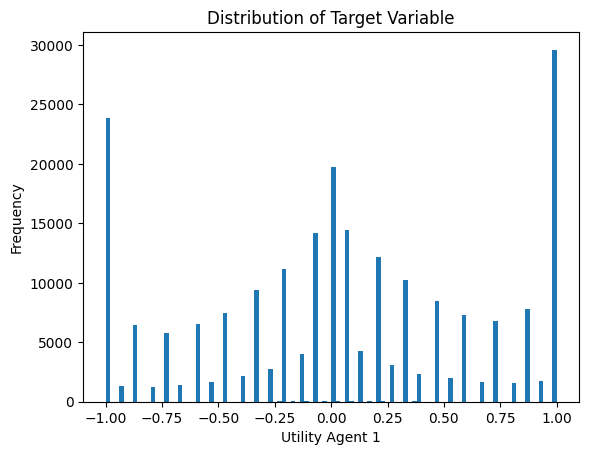

In [7]:
plt.hist(df_train['utility_agent1'], bins=100)
plt.title('Distribution of Target Variable')
plt.xlabel('Utility Agent 1')
plt.ylabel('Frequency')
plt.show()

In [8]:
split1 = pickle.load(open('../data/splits/cv1_Game.pkl', 'rb'))
split2 = pickle.load(open('../data/splits/cv2_Game.pkl', 'rb'))
split3 = pickle.load(open('../data/splits/cv3_Game.pkl', 'rb'))

# split1 = pickle.load(open('../data/splits/cv1_GameRulesetName.pkl', 'rb'))
# split2 = pickle.load(open('../data/splits/cv2_GameRulesetName.pkl', 'rb'))
# split3 = pickle.load(open('../data/splits/cv3_GameRulesetName.pkl', 'rb'))

***
### train model

In [9]:
def get_feature_importance(model, importance_type='PredictionValuesChange'):
    """
    Get feature importance from a trained CatBoost model
    
    Args:
        model: Trained CatBoost model
        importance_type: Type of feature importance to calculate
            Options: 'PredictionValuesChange', 'LossFunctionChange', 
            'ShapValues', 'Interaction', 'TopKitty'
        
    Returns:
        pandas.DataFrame: DataFrame containing feature names and their importance scores
    """
    # Get feature importance scores
    importance_scores = model.get_feature_importance(type=importance_type)
    feature_names = model.feature_names_
    
    # Create dataframe with feature names and importance scores
    importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': importance_scores
    }).sort_values('importance', ascending=False, ignore_index=True)
    
    return importance_df


def plot_feature_importance(importance_df, top_n=100):
    plot_df = importance_df.head(top_n)
    
    plt.figure(figsize=(15, 5))
    plt.bar(x=range(len(plot_df)), height=plot_df['importance'])
    plt.xticks(range(len(plot_df)), plot_df['feature'], rotation=45, ha='right', fontsize=8)
    plt.ylabel('Importance Score')
    plt.title(f'Top {top_n} Most Important Features')
    plt.tight_layout()
    plt.show()

In [10]:
def train_models(
        df_train,
        numerical_cols,
        categorical_cols,
        text_cols,
        target='utility_agent1',
        split_list=None,
    ):
    # Define the parameters for CatBoost
    params = {

        'objective': "RMSE",
        'learning_rate': 0.1,
        'depth': 10,
        'iterations': 3000,
        'eval_metric': 'RMSE',
        'verbose': 0,
        'random_seed': 2112,
        'l2_leaf_reg': 1.,
        'random_strength': 0.2,
        'min_data_in_leaf': 50,
        'rsm': 0.8,
        'bagging_temperature' : 0.50,

        # 'text_processing': {
        #     'tokenizers': [{
        #         'tokenizer_id': 'Space',  # or 'GPT', 'Bert', etc.
        #         'separator_type': 'Space'
        #     }],
        #     'dictionaries': [{
        #         'dictionary_id': 'BiGram',
        #         'max_dictionary_size': '50000',
        #         'occurrence_lower_bound': '3',
        #         'gram_order': '2'
        #     }],
        #     'feature_calcers': [{
        #         'calcer_type': 'BoW',  # or 'NaiveBayes', 'BM25'
        #         'dictionary_id': 'BiGram'
        #     }]
        # }


        # # Text processing parameters to mimic TF-IDF
        # 'tokenizers': [{
        #     'tokenizer_id': 'Space',
        #     'separator_type': 'ByDelimiter',
        #     'delimiter': ' '
        # }],
        # 'dictionaries': [{
        #     'dictionary_id': 'NgramDict',
        #     'max_dictionary_size': '500',  # Match max_features=500
        #     'occurrence_lower_bound': '3',
        #     'gram_order': '3',  # Maximum n-gram size
        #     'min_gram_order': '2'  # Minimum n-gram size
        # }],
        # 'feature_calcers': [{
        #     'calcer_type': 'BoW',  # Most similar to TF-IDF
        #     'dictionary_id': 'NgramDict'
        # }],


        # 'tokenizers': [{
        #     'tokenizer_id': 'Space',
        #     'delimiter': ' ',
        #     'separator_type': 'ByDelimiter'
        # }],
        # 'dictionaries': [{
        #     'dictionary_id': 'Word',
        #     'max_dictionary_size': '50000',
        #     'occurrence_lower_bound': '3'
        # }],
        # 'feature_calcers': [{
        #     'calcer_type': 'BoW',
        #     'dictionary_id': 'Word',
        # }]
    }
    # Obtained with optuna
    # params = {
    #     'objective': 'RMSE',
    #     'verbose': False,
    #     'random_seed': 2112,
    #     'learning_rate': 0.1,
    #     'iterations': 3000,
    #     'bootstrap_type': 'Bayesian',
    #     'sampling_frequency': 'PerTreeLevel',
    #     'depth': 10,
    #     'l2_leaf_reg': 0.9359292512255313,
    #     'random_strength': 0.16693257025108216,
    #     'bagging_temperature': 0.15967219011745193,
    #     'rsm': 0.548125395769786,
    #     'min_data_in_leaf': 102,
    #     'max_ctr_complexity': 10
    # }

    trained_models = []
    oof = pd.DataFrame(
        index=df_train.index,
        columns=[f'{target}_true', f'{target}_pred', 'fold']
    )
    oof_scores = []
    feat_importance_dfs = []

    # Perform cross-validation
    for fold, (train_index, val_index) in enumerate(split_list, 1):
        print(f"Fold {fold}")
        
        # Split the data
        X_train, X_valid = df_train.iloc[train_index], df_train.iloc[val_index]
        y_train, y_valid = X_train[target], X_valid[target]

        # Initialize CatBoost Pool
        train_pool = cb.Pool(
            # data=X_train[numerical_cols + categorical_cols + text_cols],
            data=X_train[numerical_cols + categorical_cols],
            label=y_train,
            cat_features=categorical_cols,
            # text_features=text_cols
        )
        val_pool = cb.Pool(
            # data=X_valid[numerical_cols + categorical_cols + text_cols],
            data=X_valid[numerical_cols + categorical_cols],
            label=y_valid,
            cat_features=categorical_cols,
            # text_features=text_cols
        )
        
        # Initialize CatBoost Regressor
        model = cb.CatBoostRegressor(**params)
        
        # Train the model
        model.fit(
            train_pool,
            eval_set=val_pool,
            use_best_model=True,
            verbose=50
        )

        feat_importance = get_feature_importance(model)
        feat_importance = feat_importance.rename(columns={'importance': f'importance_f{fold}'})
        feat_importance_dfs.append(feat_importance)
        plot_feature_importance(feat_importance.rename(columns={f'importance_f{fold}': 'importance'}))
        
        # Save the trained model to the list
        trained_models.append(model)

        # Predict on validation set
        y_pred = model.predict(val_pool)

        # Save out-of-fold predictions
        oof.loc[val_index, f'{target}_true'] = y_valid
        oof.loc[val_index, f'{target}_pred'] = y_pred
        oof.loc[val_index, 'fold'] = fold
        
        # Compute RMSE
        y_pred = np.clip(y_pred, -1, 1)
        rmse = np.sqrt(np.mean((y_pred - y_valid) ** 2))
        print(f"Fold {fold} - RMSE: {rmse}")

        # Save RMSE to the list
        oof_scores.append(rmse)

    # Combine feature importance dataframes
    importance_df = feat_importance_dfs[0]
    for df in feat_importance_dfs[1:]:
        importance_df = importance_df.merge(df, on='feature')
    
    # Calculate mean importance across folds
    importance_cols = [col for col in importance_df.columns if col.startswith('importance_f')]
    importance_df['importance_mean'] = importance_df[importance_cols].mean(axis=1)
    importance_df = importance_df.sort_values('importance_mean', ascending=False, ignore_index=True)
    importance_df['importance_relative'] = (
        importance_df['importance_mean'] / 
        importance_df['importance_mean'].sum()
    )

    # Print the list of oof scores and average oof score
    print("List of oof scores:", oof_scores)
    print("Average oof score:", np.mean(oof_scores))

    return trained_models, oof, oof_scores, importance_df

Fold 1


0:	learn: 0.6134137	test: 0.5490571	best: 0.5490571 (0)	total: 155ms	remaining: 7m 44s


50:	learn: 0.3815358	test: 0.4630079	best: 0.4630079 (50)	total: 4.61s	remaining: 4m 26s


100:	learn: 0.3434111	test: 0.4441630	best: 0.4441630 (100)	total: 9.28s	remaining: 4m 26s


150:	learn: 0.3203931	test: 0.4368305	best: 0.4368305 (150)	total: 13.9s	remaining: 4m 22s


200:	learn: 0.3047495	test: 0.4328266	best: 0.4328266 (200)	total: 18.5s	remaining: 4m 17s


250:	learn: 0.2931061	test: 0.4300616	best: 0.4300616 (250)	total: 23.2s	remaining: 4m 14s


300:	learn: 0.2834265	test: 0.4285056	best: 0.4285056 (300)	total: 27.9s	remaining: 4m 10s


350:	learn: 0.2754998	test: 0.4278411	best: 0.4278411 (350)	total: 32.6s	remaining: 4m 6s


400:	learn: 0.2683956	test: 0.4270106	best: 0.4269679 (386)	total: 37.3s	remaining: 4m 2s


450:	learn: 0.2619032	test: 0.4259473	best: 0.4259473 (450)	total: 42s	remaining: 3m 57s


500:	learn: 0.2563999	test: 0.4251106	best: 0.4251106 (500)	total: 46.7s	remaining: 3m 53s


550:	learn: 0.2514317	test: 0.4248070	best: 0.4248070 (550)	total: 51.3s	remaining: 3m 48s


600:	learn: 0.2472752	test: 0.4247412	best: 0.4247412 (600)	total: 56s	remaining: 3m 43s


650:	learn: 0.2432904	test: 0.4240330	best: 0.4240330 (650)	total: 1m	remaining: 3m 39s


700:	learn: 0.2393333	test: 0.4237730	best: 0.4237501 (699)	total: 1m 5s	remaining: 3m 34s


750:	learn: 0.2361348	test: 0.4236450	best: 0.4235394 (743)	total: 1m 9s	remaining: 3m 29s


800:	learn: 0.2329428	test: 0.4234473	best: 0.4234068 (784)	total: 1m 14s	remaining: 3m 24s


850:	learn: 0.2298630	test: 0.4232624	best: 0.4232579 (849)	total: 1m 19s	remaining: 3m 20s


900:	learn: 0.2268667	test: 0.4231708	best: 0.4231708 (900)	total: 1m 24s	remaining: 3m 15s


950:	learn: 0.2242112	test: 0.4232043	best: 0.4231546 (905)	total: 1m 28s	remaining: 3m 10s


1000:	learn: 0.2212819	test: 0.4229953	best: 0.4229939 (999)	total: 1m 33s	remaining: 3m 6s


1050:	learn: 0.2188559	test: 0.4227589	best: 0.4226885 (1043)	total: 1m 37s	remaining: 3m 1s


1100:	learn: 0.2164785	test: 0.4228109	best: 0.4226885 (1043)	total: 1m 42s	remaining: 2m 57s


1150:	learn: 0.2142841	test: 0.4226893	best: 0.4226493 (1134)	total: 1m 47s	remaining: 2m 52s


1200:	learn: 0.2119367	test: 0.4226874	best: 0.4226368 (1157)	total: 1m 51s	remaining: 2m 47s


1250:	learn: 0.2100056	test: 0.4226837	best: 0.4226368 (1157)	total: 1m 56s	remaining: 2m 42s


1300:	learn: 0.2080465	test: 0.4223029	best: 0.4222941 (1290)	total: 2m 1s	remaining: 2m 38s


1350:	learn: 0.2061951	test: 0.4222390	best: 0.4222145 (1343)	total: 2m 5s	remaining: 2m 33s


1400:	learn: 0.2043616	test: 0.4223176	best: 0.4222145 (1343)	total: 2m 10s	remaining: 2m 29s


1450:	learn: 0.2024996	test: 0.4222486	best: 0.4222145 (1343)	total: 2m 15s	remaining: 2m 24s


1500:	learn: 0.2007022	test: 0.4222435	best: 0.4221915 (1482)	total: 2m 19s	remaining: 2m 19s


1550:	learn: 0.1986792	test: 0.4222874	best: 0.4221915 (1482)	total: 2m 24s	remaining: 2m 14s


1600:	learn: 0.1970453	test: 0.4222503	best: 0.4221915 (1482)	total: 2m 29s	remaining: 2m 10s


1650:	learn: 0.1955331	test: 0.4222210	best: 0.4221915 (1482)	total: 2m 33s	remaining: 2m 5s


1700:	learn: 0.1939150	test: 0.4221690	best: 0.4221622 (1662)	total: 2m 38s	remaining: 2m


1750:	learn: 0.1922532	test: 0.4221966	best: 0.4221622 (1662)	total: 2m 43s	remaining: 1m 56s


1800:	learn: 0.1905114	test: 0.4221582	best: 0.4220732 (1773)	total: 2m 47s	remaining: 1m 51s


1850:	learn: 0.1889847	test: 0.4220765	best: 0.4220732 (1773)	total: 2m 52s	remaining: 1m 46s


1900:	learn: 0.1873675	test: 0.4220092	best: 0.4220051 (1896)	total: 2m 56s	remaining: 1m 42s


1950:	learn: 0.1857692	test: 0.4218633	best: 0.4218604 (1947)	total: 3m 1s	remaining: 1m 37s


2000:	learn: 0.1843737	test: 0.4218578	best: 0.4218326 (1990)	total: 3m 6s	remaining: 1m 32s


2050:	learn: 0.1829638	test: 0.4218587	best: 0.4218326 (1990)	total: 3m 10s	remaining: 1m 28s


2100:	learn: 0.1815020	test: 0.4218243	best: 0.4218239 (2088)	total: 3m 15s	remaining: 1m 23s


2150:	learn: 0.1802677	test: 0.4218509	best: 0.4218206 (2102)	total: 3m 20s	remaining: 1m 18s


2200:	learn: 0.1788511	test: 0.4218982	best: 0.4218206 (2102)	total: 3m 24s	remaining: 1m 14s


2250:	learn: 0.1774953	test: 0.4219259	best: 0.4218206 (2102)	total: 3m 29s	remaining: 1m 9s


2300:	learn: 0.1762973	test: 0.4219245	best: 0.4218206 (2102)	total: 3m 34s	remaining: 1m 5s


2350:	learn: 0.1749890	test: 0.4218826	best: 0.4218206 (2102)	total: 3m 38s	remaining: 1m


2400:	learn: 0.1737854	test: 0.4218866	best: 0.4218206 (2102)	total: 3m 43s	remaining: 55.8s


2450:	learn: 0.1725413	test: 0.4218605	best: 0.4218206 (2102)	total: 3m 48s	remaining: 51.1s


2500:	learn: 0.1713828	test: 0.4218630	best: 0.4218206 (2102)	total: 3m 52s	remaining: 46.5s


2550:	learn: 0.1701505	test: 0.4219025	best: 0.4218206 (2102)	total: 3m 57s	remaining: 41.8s


2600:	learn: 0.1689504	test: 0.4218902	best: 0.4218206 (2102)	total: 4m 2s	remaining: 37.2s


2650:	learn: 0.1678130	test: 0.4218601	best: 0.4218206 (2102)	total: 4m 6s	remaining: 32.5s


2700:	learn: 0.1666847	test: 0.4219497	best: 0.4218206 (2102)	total: 4m 11s	remaining: 27.9s


2750:	learn: 0.1656066	test: 0.4219444	best: 0.4218206 (2102)	total: 4m 16s	remaining: 23.2s


2800:	learn: 0.1645023	test: 0.4219407	best: 0.4218206 (2102)	total: 4m 20s	remaining: 18.5s


2850:	learn: 0.1632992	test: 0.4219231	best: 0.4218206 (2102)	total: 4m 25s	remaining: 13.9s


2900:	learn: 0.1623453	test: 0.4219691	best: 0.4218206 (2102)	total: 4m 30s	remaining: 9.22s


2950:	learn: 0.1612650	test: 0.4219588	best: 0.4218206 (2102)	total: 4m 34s	remaining: 4.56s


2999:	learn: 0.1602792	test: 0.4219436	best: 0.4218206 (2102)	total: 4m 39s	remaining: 0us

bestTest = 0.4218206437
bestIteration = 2102

Shrink model to first 2103 iterations.


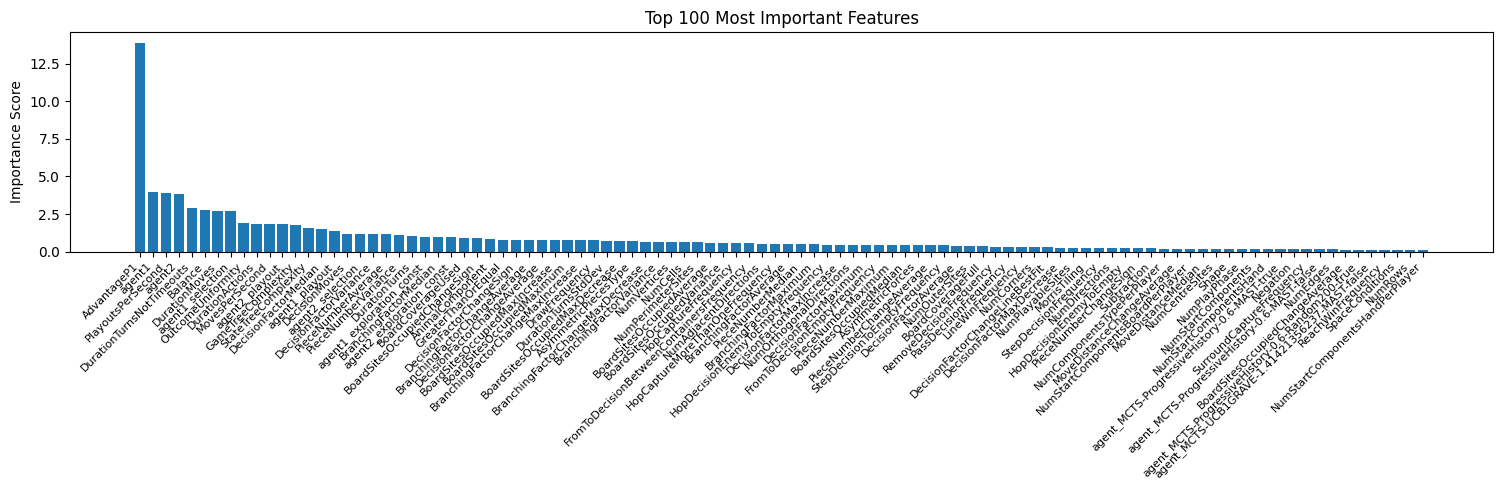

Fold 1 - RMSE: 0.42137958427998606
Fold 2


0:	learn: 0.6067612	test: 0.5837688	best: 0.5837688 (0)	total: 93ms	remaining: 4m 38s


50:	learn: 0.3868914	test: 0.4754770	best: 0.4754770 (50)	total: 4.59s	remaining: 4m 25s


100:	learn: 0.3482298	test: 0.4626240	best: 0.4626240 (100)	total: 9.37s	remaining: 4m 28s


150:	learn: 0.3257961	test: 0.4575404	best: 0.4575404 (150)	total: 14s	remaining: 4m 24s


200:	learn: 0.3103747	test: 0.4540875	best: 0.4540746 (197)	total: 18.8s	remaining: 4m 21s


250:	learn: 0.2992848	test: 0.4520073	best: 0.4519971 (247)	total: 23.5s	remaining: 4m 17s


300:	learn: 0.2894506	test: 0.4504629	best: 0.4504509 (299)	total: 28.1s	remaining: 4m 12s


350:	learn: 0.2816353	test: 0.4497536	best: 0.4496451 (345)	total: 32.9s	remaining: 4m 8s


400:	learn: 0.2743982	test: 0.4485001	best: 0.4485001 (400)	total: 37.7s	remaining: 4m 4s


450:	learn: 0.2687124	test: 0.4475300	best: 0.4475300 (450)	total: 42.5s	remaining: 4m


500:	learn: 0.2631727	test: 0.4465630	best: 0.4465630 (500)	total: 47.4s	remaining: 3m 56s


550:	learn: 0.2581835	test: 0.4460561	best: 0.4460446 (537)	total: 52.2s	remaining: 3m 51s


600:	learn: 0.2539543	test: 0.4460209	best: 0.4460209 (600)	total: 57s	remaining: 3m 47s


650:	learn: 0.2499553	test: 0.4454840	best: 0.4454840 (650)	total: 1m 1s	remaining: 3m 43s


700:	learn: 0.2461113	test: 0.4450997	best: 0.4450997 (700)	total: 1m 6s	remaining: 3m 38s


750:	learn: 0.2429383	test: 0.4448423	best: 0.4448423 (750)	total: 1m 11s	remaining: 3m 33s


800:	learn: 0.2397298	test: 0.4443723	best: 0.4443563 (798)	total: 1m 16s	remaining: 3m 29s


850:	learn: 0.2366836	test: 0.4439549	best: 0.4439518 (849)	total: 1m 21s	remaining: 3m 24s


900:	learn: 0.2336455	test: 0.4440236	best: 0.4439240 (853)	total: 1m 25s	remaining: 3m 20s


950:	learn: 0.2307521	test: 0.4436941	best: 0.4436941 (950)	total: 1m 30s	remaining: 3m 15s


1000:	learn: 0.2281759	test: 0.4435206	best: 0.4434847 (992)	total: 1m 35s	remaining: 3m 11s


1050:	learn: 0.2256698	test: 0.4433292	best: 0.4433256 (1049)	total: 1m 40s	remaining: 3m 6s


1100:	learn: 0.2232974	test: 0.4431474	best: 0.4431474 (1100)	total: 1m 45s	remaining: 3m 2s


1150:	learn: 0.2209347	test: 0.4430306	best: 0.4430140 (1146)	total: 1m 50s	remaining: 2m 57s


1200:	learn: 0.2187330	test: 0.4428430	best: 0.4427926 (1193)	total: 1m 55s	remaining: 2m 52s


1250:	learn: 0.2168015	test: 0.4426762	best: 0.4426762 (1250)	total: 2m	remaining: 2m 48s


1300:	learn: 0.2148023	test: 0.4426209	best: 0.4425751 (1295)	total: 2m 5s	remaining: 2m 43s


1350:	learn: 0.2127511	test: 0.4425794	best: 0.4425287 (1313)	total: 2m 10s	remaining: 2m 38s


1400:	learn: 0.2109055	test: 0.4423907	best: 0.4423907 (1400)	total: 2m 15s	remaining: 2m 34s


1450:	learn: 0.2091628	test: 0.4422657	best: 0.4422657 (1450)	total: 2m 19s	remaining: 2m 29s


1500:	learn: 0.2075819	test: 0.4422485	best: 0.4422396 (1490)	total: 2m 24s	remaining: 2m 24s


1550:	learn: 0.2058925	test: 0.4421689	best: 0.4421689 (1550)	total: 2m 29s	remaining: 2m 19s


1600:	learn: 0.2042211	test: 0.4421555	best: 0.4421519 (1599)	total: 2m 34s	remaining: 2m 15s


1650:	learn: 0.2024300	test: 0.4420798	best: 0.4420578 (1629)	total: 2m 39s	remaining: 2m 10s


1700:	learn: 0.2006641	test: 0.4421498	best: 0.4420578 (1629)	total: 2m 44s	remaining: 2m 5s


1750:	learn: 0.1990005	test: 0.4421999	best: 0.4420578 (1629)	total: 2m 49s	remaining: 2m


1800:	learn: 0.1975512	test: 0.4421409	best: 0.4420578 (1629)	total: 2m 54s	remaining: 1m 56s


1850:	learn: 0.1961161	test: 0.4419422	best: 0.4419225 (1843)	total: 2m 59s	remaining: 1m 51s


1900:	learn: 0.1946066	test: 0.4417254	best: 0.4417241 (1899)	total: 3m 4s	remaining: 1m 46s


1950:	learn: 0.1930422	test: 0.4417446	best: 0.4416986 (1919)	total: 3m 9s	remaining: 1m 41s


2000:	learn: 0.1915862	test: 0.4418474	best: 0.4416986 (1919)	total: 3m 14s	remaining: 1m 36s


2050:	learn: 0.1902754	test: 0.4417960	best: 0.4416986 (1919)	total: 3m 19s	remaining: 1m 32s


2100:	learn: 0.1888369	test: 0.4416680	best: 0.4416680 (2100)	total: 3m 24s	remaining: 1m 27s


2150:	learn: 0.1874792	test: 0.4417852	best: 0.4416504 (2120)	total: 3m 28s	remaining: 1m 22s


2200:	learn: 0.1861069	test: 0.4418527	best: 0.4416504 (2120)	total: 3m 33s	remaining: 1m 17s


2250:	learn: 0.1846228	test: 0.4418710	best: 0.4416504 (2120)	total: 3m 38s	remaining: 1m 12s


2300:	learn: 0.1832970	test: 0.4418320	best: 0.4416504 (2120)	total: 3m 43s	remaining: 1m 7s


2350:	learn: 0.1818294	test: 0.4418534	best: 0.4416504 (2120)	total: 3m 48s	remaining: 1m 3s


2400:	learn: 0.1805267	test: 0.4418056	best: 0.4416504 (2120)	total: 3m 53s	remaining: 58.3s


2450:	learn: 0.1792598	test: 0.4417397	best: 0.4416504 (2120)	total: 3m 58s	remaining: 53.4s


2500:	learn: 0.1780008	test: 0.4417512	best: 0.4416504 (2120)	total: 4m 3s	remaining: 48.6s


2550:	learn: 0.1767761	test: 0.4417719	best: 0.4416504 (2120)	total: 4m 8s	remaining: 43.7s


2600:	learn: 0.1755425	test: 0.4418516	best: 0.4416504 (2120)	total: 4m 13s	remaining: 38.9s


2650:	learn: 0.1743784	test: 0.4418037	best: 0.4416504 (2120)	total: 4m 18s	remaining: 34s


2700:	learn: 0.1731907	test: 0.4417175	best: 0.4416504 (2120)	total: 4m 23s	remaining: 29.2s


2750:	learn: 0.1719611	test: 0.4416527	best: 0.4416442 (2739)	total: 4m 28s	remaining: 24.3s


2800:	learn: 0.1709117	test: 0.4416390	best: 0.4416216 (2787)	total: 4m 33s	remaining: 19.4s


2850:	learn: 0.1697611	test: 0.4416046	best: 0.4415720 (2825)	total: 4m 38s	remaining: 14.6s


2900:	learn: 0.1686322	test: 0.4416162	best: 0.4415704 (2871)	total: 4m 43s	remaining: 9.67s


2950:	learn: 0.1674825	test: 0.4416509	best: 0.4415704 (2871)	total: 4m 48s	remaining: 4.79s


2999:	learn: 0.1663860	test: 0.4415816	best: 0.4415704 (2871)	total: 4m 53s	remaining: 0us

bestTest = 0.4415704349
bestIteration = 2871

Shrink model to first 2872 iterations.


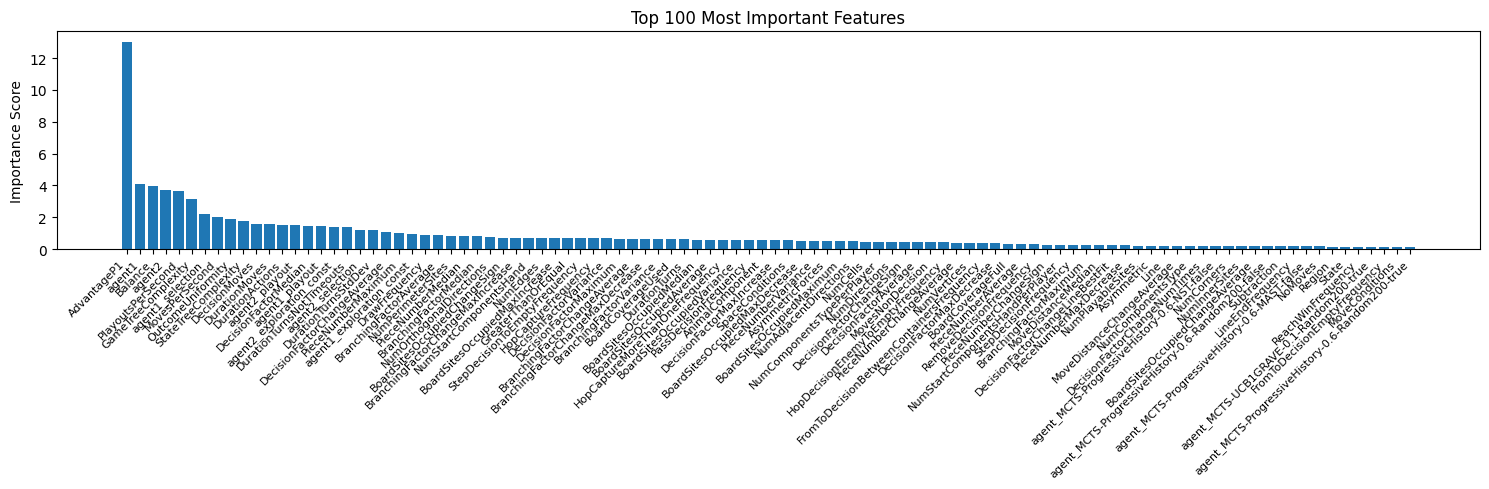

Fold 2 - RMSE: 0.4411871527982296
Fold 3


0:	learn: 0.6018016	test: 0.5986047	best: 0.5986047 (0)	total: 86.6ms	remaining: 4m 19s


50:	learn: 0.3887328	test: 0.4739382	best: 0.4739382 (50)	total: 4.67s	remaining: 4m 30s


100:	learn: 0.3492116	test: 0.4570176	best: 0.4570176 (100)	total: 9.61s	remaining: 4m 35s


150:	learn: 0.3268745	test: 0.4482109	best: 0.4482109 (150)	total: 14.5s	remaining: 4m 33s


200:	learn: 0.3116338	test: 0.4456375	best: 0.4453804 (195)	total: 19.4s	remaining: 4m 30s


250:	learn: 0.2995557	test: 0.4429432	best: 0.4429127 (247)	total: 24.2s	remaining: 4m 24s


300:	learn: 0.2896692	test: 0.4414196	best: 0.4414196 (300)	total: 29s	remaining: 4m 19s


350:	learn: 0.2811775	test: 0.4402743	best: 0.4402743 (350)	total: 33.7s	remaining: 4m 14s


400:	learn: 0.2741154	test: 0.4392867	best: 0.4392867 (400)	total: 38.4s	remaining: 4m 9s


450:	learn: 0.2683275	test: 0.4383873	best: 0.4383873 (450)	total: 43.4s	remaining: 4m 5s


500:	learn: 0.2626415	test: 0.4375573	best: 0.4375573 (500)	total: 48.2s	remaining: 4m


550:	learn: 0.2576568	test: 0.4371328	best: 0.4371328 (550)	total: 53s	remaining: 3m 55s


600:	learn: 0.2533355	test: 0.4366727	best: 0.4366703 (599)	total: 57.8s	remaining: 3m 50s


650:	learn: 0.2491337	test: 0.4364131	best: 0.4363700 (634)	total: 1m 2s	remaining: 3m 45s


700:	learn: 0.2448820	test: 0.4361892	best: 0.4361786 (699)	total: 1m 7s	remaining: 3m 41s


750:	learn: 0.2411490	test: 0.4360478	best: 0.4360135 (745)	total: 1m 12s	remaining: 3m 36s


800:	learn: 0.2376275	test: 0.4358462	best: 0.4358358 (797)	total: 1m 17s	remaining: 3m 31s


850:	learn: 0.2344322	test: 0.4355317	best: 0.4355317 (850)	total: 1m 21s	remaining: 3m 26s


900:	learn: 0.2316384	test: 0.4353062	best: 0.4352927 (898)	total: 1m 26s	remaining: 3m 22s


950:	learn: 0.2288438	test: 0.4353016	best: 0.4352927 (898)	total: 1m 31s	remaining: 3m 17s


1000:	learn: 0.2264148	test: 0.4352914	best: 0.4352313 (968)	total: 1m 36s	remaining: 3m 12s


1050:	learn: 0.2237975	test: 0.4351050	best: 0.4350991 (1049)	total: 1m 41s	remaining: 3m 7s


1100:	learn: 0.2213713	test: 0.4350226	best: 0.4350226 (1100)	total: 1m 46s	remaining: 3m 3s


1150:	learn: 0.2191186	test: 0.4350030	best: 0.4349570 (1120)	total: 1m 51s	remaining: 2m 58s


1200:	learn: 0.2170776	test: 0.4349303	best: 0.4349299 (1199)	total: 1m 55s	remaining: 2m 53s


1250:	learn: 0.2148650	test: 0.4348106	best: 0.4347968 (1237)	total: 2m	remaining: 2m 48s


1300:	learn: 0.2125420	test: 0.4346309	best: 0.4346309 (1300)	total: 2m 5s	remaining: 2m 44s


1350:	learn: 0.2106477	test: 0.4344638	best: 0.4344638 (1350)	total: 2m 10s	remaining: 2m 39s


1400:	learn: 0.2087797	test: 0.4343967	best: 0.4343913 (1396)	total: 2m 15s	remaining: 2m 34s


1450:	learn: 0.2068759	test: 0.4342269	best: 0.4342197 (1448)	total: 2m 20s	remaining: 2m 29s


1500:	learn: 0.2050654	test: 0.4341877	best: 0.4341278 (1493)	total: 2m 24s	remaining: 2m 24s


1550:	learn: 0.2033060	test: 0.4341314	best: 0.4341278 (1493)	total: 2m 29s	remaining: 2m 19s


1600:	learn: 0.2016130	test: 0.4341609	best: 0.4341076 (1567)	total: 2m 34s	remaining: 2m 15s


1650:	learn: 0.1999558	test: 0.4341101	best: 0.4341009 (1647)	total: 2m 39s	remaining: 2m 10s


1700:	learn: 0.1983659	test: 0.4339466	best: 0.4339422 (1699)	total: 2m 44s	remaining: 2m 5s


1750:	learn: 0.1968166	test: 0.4338659	best: 0.4338415 (1742)	total: 2m 49s	remaining: 2m


1800:	learn: 0.1951226	test: 0.4338059	best: 0.4337999 (1796)	total: 2m 54s	remaining: 1m 55s


1850:	learn: 0.1936370	test: 0.4337875	best: 0.4337779 (1847)	total: 2m 58s	remaining: 1m 51s


1900:	learn: 0.1920952	test: 0.4337400	best: 0.4337399 (1899)	total: 3m 3s	remaining: 1m 46s


1950:	learn: 0.1906575	test: 0.4337642	best: 0.4337228 (1921)	total: 3m 8s	remaining: 1m 41s


2000:	learn: 0.1891202	test: 0.4336914	best: 0.4336182 (1972)	total: 3m 13s	remaining: 1m 36s


2050:	learn: 0.1877227	test: 0.4336791	best: 0.4336182 (1972)	total: 3m 18s	remaining: 1m 31s


2100:	learn: 0.1862808	test: 0.4337402	best: 0.4336182 (1972)	total: 3m 23s	remaining: 1m 26s


2150:	learn: 0.1849706	test: 0.4337805	best: 0.4336182 (1972)	total: 3m 28s	remaining: 1m 22s


2200:	learn: 0.1836018	test: 0.4338017	best: 0.4336182 (1972)	total: 3m 32s	remaining: 1m 17s


2250:	learn: 0.1822601	test: 0.4337680	best: 0.4336182 (1972)	total: 3m 37s	remaining: 1m 12s


2300:	learn: 0.1809475	test: 0.4338546	best: 0.4336182 (1972)	total: 3m 42s	remaining: 1m 7s


2350:	learn: 0.1797131	test: 0.4339600	best: 0.4336182 (1972)	total: 3m 47s	remaining: 1m 2s


2400:	learn: 0.1784686	test: 0.4339635	best: 0.4336182 (1972)	total: 3m 52s	remaining: 57.9s


2450:	learn: 0.1774186	test: 0.4339065	best: 0.4336182 (1972)	total: 3m 57s	remaining: 53.1s


2500:	learn: 0.1761494	test: 0.4338620	best: 0.4336182 (1972)	total: 4m 1s	remaining: 48.3s


2550:	learn: 0.1748972	test: 0.4338279	best: 0.4336182 (1972)	total: 4m 6s	remaining: 43.4s


2600:	learn: 0.1736011	test: 0.4338015	best: 0.4336182 (1972)	total: 4m 11s	remaining: 38.6s


2650:	learn: 0.1725439	test: 0.4338433	best: 0.4336182 (1972)	total: 4m 16s	remaining: 33.7s


2700:	learn: 0.1714834	test: 0.4338269	best: 0.4336182 (1972)	total: 4m 21s	remaining: 28.9s


2750:	learn: 0.1703047	test: 0.4337920	best: 0.4336182 (1972)	total: 4m 25s	remaining: 24.1s


2800:	learn: 0.1690956	test: 0.4337404	best: 0.4336182 (1972)	total: 4m 30s	remaining: 19.2s


2850:	learn: 0.1679828	test: 0.4337551	best: 0.4336182 (1972)	total: 4m 35s	remaining: 14.4s


2900:	learn: 0.1668572	test: 0.4338546	best: 0.4336182 (1972)	total: 4m 40s	remaining: 9.57s


2950:	learn: 0.1658121	test: 0.4339061	best: 0.4336182 (1972)	total: 4m 45s	remaining: 4.73s


2999:	learn: 0.1647874	test: 0.4338935	best: 0.4336182 (1972)	total: 4m 49s	remaining: 0us

bestTest = 0.4336182482
bestIteration = 1972

Shrink model to first 1973 iterations.


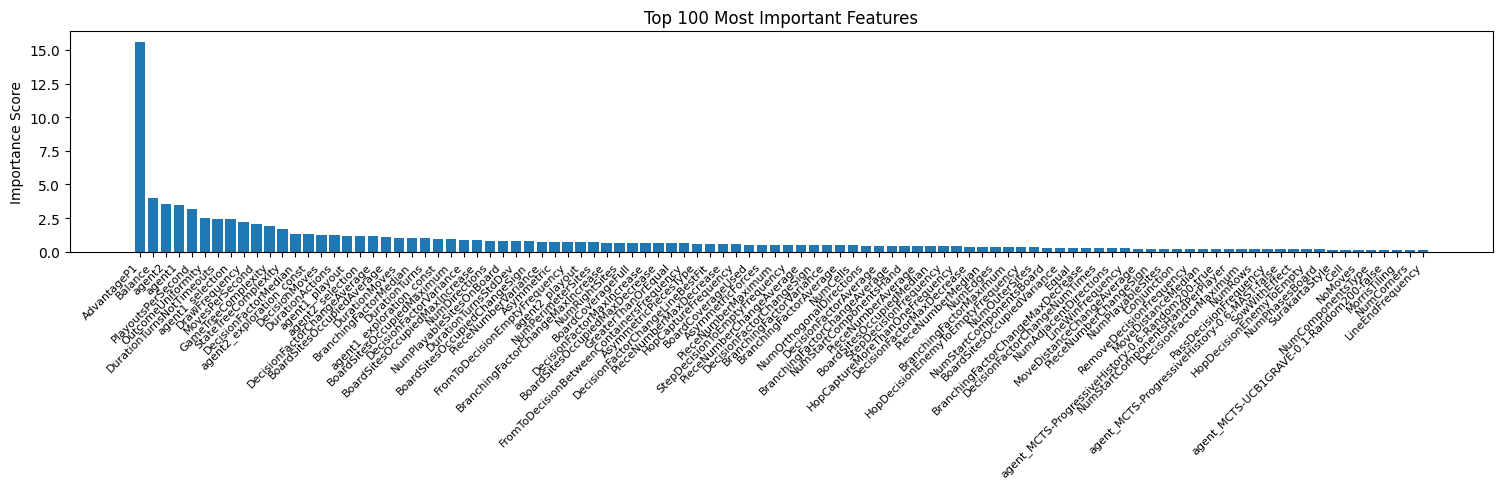

Fold 3 - RMSE: 0.4330435187384083
Fold 4


0:	learn: 0.6028278	test: 0.5907224	best: 0.5907224 (0)	total: 80.7ms	remaining: 4m 1s


50:	learn: 0.3865502	test: 0.4813970	best: 0.4813970 (50)	total: 4.69s	remaining: 4m 31s


100:	learn: 0.3496449	test: 0.4655589	best: 0.4655589 (100)	total: 9.4s	remaining: 4m 29s


150:	learn: 0.3255827	test: 0.4551219	best: 0.4551219 (150)	total: 14.1s	remaining: 4m 26s


200:	learn: 0.3094224	test: 0.4508696	best: 0.4508696 (200)	total: 18.9s	remaining: 4m 22s


250:	learn: 0.2975091	test: 0.4488711	best: 0.4488689 (248)	total: 23.5s	remaining: 4m 17s


300:	learn: 0.2874267	test: 0.4469466	best: 0.4469466 (300)	total: 28.3s	remaining: 4m 13s


350:	learn: 0.2791463	test: 0.4456395	best: 0.4456082 (349)	total: 33.1s	remaining: 4m 9s


400:	learn: 0.2721079	test: 0.4442694	best: 0.4442694 (400)	total: 37.8s	remaining: 4m 4s


450:	learn: 0.2660705	test: 0.4436982	best: 0.4436469 (445)	total: 42.6s	remaining: 4m


500:	learn: 0.2600317	test: 0.4428559	best: 0.4428544 (497)	total: 47.4s	remaining: 3m 56s


550:	learn: 0.2545797	test: 0.4425230	best: 0.4425118 (546)	total: 52.2s	remaining: 3m 52s


600:	learn: 0.2504119	test: 0.4422241	best: 0.4421858 (591)	total: 57s	remaining: 3m 47s


650:	learn: 0.2458861	test: 0.4418002	best: 0.4418002 (650)	total: 1m 1s	remaining: 3m 42s


700:	learn: 0.2419653	test: 0.4414919	best: 0.4414860 (698)	total: 1m 6s	remaining: 3m 37s


750:	learn: 0.2381734	test: 0.4409343	best: 0.4409081 (747)	total: 1m 11s	remaining: 3m 33s


800:	learn: 0.2348747	test: 0.4406805	best: 0.4406657 (777)	total: 1m 15s	remaining: 3m 28s


850:	learn: 0.2315316	test: 0.4404335	best: 0.4404333 (849)	total: 1m 20s	remaining: 3m 23s


900:	learn: 0.2286471	test: 0.4400749	best: 0.4400612 (898)	total: 1m 25s	remaining: 3m 18s


950:	learn: 0.2260973	test: 0.4397514	best: 0.4397514 (950)	total: 1m 30s	remaining: 3m 14s


1000:	learn: 0.2235444	test: 0.4393909	best: 0.4393784 (996)	total: 1m 34s	remaining: 3m 9s


1050:	learn: 0.2210385	test: 0.4392222	best: 0.4392222 (1050)	total: 1m 39s	remaining: 3m 4s


1100:	learn: 0.2186384	test: 0.4389723	best: 0.4389723 (1100)	total: 1m 44s	remaining: 3m


1150:	learn: 0.2163617	test: 0.4388219	best: 0.4387978 (1142)	total: 1m 49s	remaining: 2m 55s


1200:	learn: 0.2142425	test: 0.4387463	best: 0.4387452 (1198)	total: 1m 54s	remaining: 2m 50s


1250:	learn: 0.2121157	test: 0.4386432	best: 0.4386216 (1225)	total: 1m 58s	remaining: 2m 46s


1300:	learn: 0.2098753	test: 0.4387471	best: 0.4386216 (1225)	total: 2m 3s	remaining: 2m 41s


1350:	learn: 0.2077777	test: 0.4386100	best: 0.4386100 (1350)	total: 2m 8s	remaining: 2m 36s


1400:	learn: 0.2058553	test: 0.4385511	best: 0.4385267 (1385)	total: 2m 13s	remaining: 2m 32s


1450:	learn: 0.2041700	test: 0.4386029	best: 0.4385267 (1385)	total: 2m 18s	remaining: 2m 27s


1500:	learn: 0.2024630	test: 0.4385864	best: 0.4385206 (1484)	total: 2m 22s	remaining: 2m 22s


1550:	learn: 0.2007164	test: 0.4385234	best: 0.4385053 (1536)	total: 2m 27s	remaining: 2m 18s


1600:	learn: 0.1991142	test: 0.4384273	best: 0.4384273 (1600)	total: 2m 32s	remaining: 2m 13s


1650:	learn: 0.1973666	test: 0.4384030	best: 0.4383734 (1646)	total: 2m 37s	remaining: 2m 8s


1700:	learn: 0.1956430	test: 0.4383726	best: 0.4383496 (1679)	total: 2m 42s	remaining: 2m 3s


1750:	learn: 0.1940710	test: 0.4383563	best: 0.4383496 (1679)	total: 2m 46s	remaining: 1m 59s


1800:	learn: 0.1924744	test: 0.4382897	best: 0.4382375 (1772)	total: 2m 51s	remaining: 1m 54s


1850:	learn: 0.1909951	test: 0.4383399	best: 0.4382375 (1772)	total: 2m 56s	remaining: 1m 49s


1900:	learn: 0.1893337	test: 0.4383582	best: 0.4382375 (1772)	total: 3m 1s	remaining: 1m 44s


1950:	learn: 0.1879988	test: 0.4384020	best: 0.4382375 (1772)	total: 3m 6s	remaining: 1m 40s


2000:	learn: 0.1866179	test: 0.4383734	best: 0.4382375 (1772)	total: 3m 11s	remaining: 1m 35s


2050:	learn: 0.1853580	test: 0.4383696	best: 0.4382375 (1772)	total: 3m 15s	remaining: 1m 30s


2100:	learn: 0.1839195	test: 0.4383264	best: 0.4382375 (1772)	total: 3m 20s	remaining: 1m 25s


2150:	learn: 0.1823692	test: 0.4383687	best: 0.4382375 (1772)	total: 3m 25s	remaining: 1m 21s


2200:	learn: 0.1810287	test: 0.4384118	best: 0.4382375 (1772)	total: 3m 30s	remaining: 1m 16s


2250:	learn: 0.1797659	test: 0.4384480	best: 0.4382375 (1772)	total: 3m 35s	remaining: 1m 11s


2300:	learn: 0.1784442	test: 0.4383665	best: 0.4382375 (1772)	total: 3m 40s	remaining: 1m 7s


2350:	learn: 0.1772304	test: 0.4383291	best: 0.4382375 (1772)	total: 3m 45s	remaining: 1m 2s


2400:	learn: 0.1760695	test: 0.4382796	best: 0.4382375 (1772)	total: 3m 50s	remaining: 57.5s


2450:	learn: 0.1748977	test: 0.4382630	best: 0.4382375 (1772)	total: 3m 55s	remaining: 52.7s


2500:	learn: 0.1736649	test: 0.4382205	best: 0.4382164 (2498)	total: 3m 59s	remaining: 47.9s


2550:	learn: 0.1725262	test: 0.4382456	best: 0.4382164 (2498)	total: 4m 4s	remaining: 43.1s


2600:	learn: 0.1712811	test: 0.4382781	best: 0.4382164 (2498)	total: 4m 9s	remaining: 38.3s


2650:	learn: 0.1701088	test: 0.4382652	best: 0.4382164 (2498)	total: 4m 14s	remaining: 33.5s


2700:	learn: 0.1689496	test: 0.4383025	best: 0.4382164 (2498)	total: 4m 19s	remaining: 28.7s


2750:	learn: 0.1678699	test: 0.4382898	best: 0.4382164 (2498)	total: 4m 24s	remaining: 23.9s


2800:	learn: 0.1667284	test: 0.4383214	best: 0.4382164 (2498)	total: 4m 29s	remaining: 19.1s


2850:	learn: 0.1656559	test: 0.4382804	best: 0.4382164 (2498)	total: 4m 33s	remaining: 14.3s


2900:	learn: 0.1646160	test: 0.4382415	best: 0.4382164 (2498)	total: 4m 38s	remaining: 9.51s


2950:	learn: 0.1635884	test: 0.4382075	best: 0.4381700 (2921)	total: 4m 43s	remaining: 4.71s


2999:	learn: 0.1625402	test: 0.4381695	best: 0.4381678 (2998)	total: 4m 48s	remaining: 0us

bestTest = 0.4381678348
bestIteration = 2998

Shrink model to first 2999 iterations.


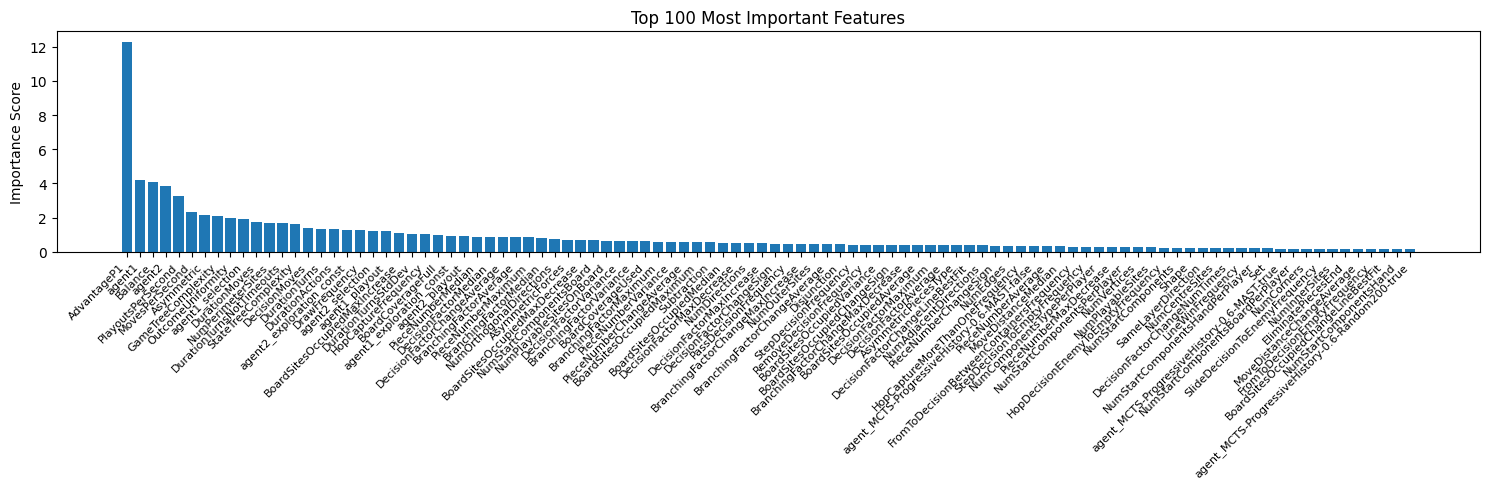

Fold 4 - RMSE: 0.4374463004161349
Fold 5


0:	learn: 0.6170244	test: 0.5423690	best: 0.5423690 (0)	total: 77.6ms	remaining: 3m 52s


50:	learn: 0.3935601	test: 0.4478120	best: 0.4478120 (50)	total: 4.65s	remaining: 4m 28s


100:	learn: 0.3541120	test: 0.4271470	best: 0.4271470 (100)	total: 9.48s	remaining: 4m 32s


150:	learn: 0.3306051	test: 0.4179165	best: 0.4179165 (150)	total: 14.2s	remaining: 4m 28s


200:	learn: 0.3154057	test: 0.4140389	best: 0.4139709 (199)	total: 19s	remaining: 4m 24s


250:	learn: 0.3031468	test: 0.4110502	best: 0.4110502 (250)	total: 23.8s	remaining: 4m 20s


300:	learn: 0.2930110	test: 0.4095361	best: 0.4095361 (300)	total: 28.4s	remaining: 4m 15s


350:	learn: 0.2848443	test: 0.4082900	best: 0.4082900 (350)	total: 33.2s	remaining: 4m 10s


400:	learn: 0.2776363	test: 0.4067680	best: 0.4067179 (398)	total: 38s	remaining: 4m 6s


450:	learn: 0.2707998	test: 0.4060176	best: 0.4059953 (449)	total: 42.7s	remaining: 4m 1s


500:	learn: 0.2650129	test: 0.4050672	best: 0.4050341 (497)	total: 47.5s	remaining: 3m 56s


550:	learn: 0.2600149	test: 0.4044905	best: 0.4044667 (548)	total: 52.1s	remaining: 3m 51s


600:	learn: 0.2548941	test: 0.4037907	best: 0.4037907 (600)	total: 56.9s	remaining: 3m 47s


650:	learn: 0.2501048	test: 0.4033824	best: 0.4033824 (650)	total: 1m 1s	remaining: 3m 42s


700:	learn: 0.2462095	test: 0.4031538	best: 0.4031187 (697)	total: 1m 6s	remaining: 3m 38s


750:	learn: 0.2425609	test: 0.4029070	best: 0.4028664 (746)	total: 1m 11s	remaining: 3m 33s


800:	learn: 0.2392622	test: 0.4031278	best: 0.4028664 (746)	total: 1m 16s	remaining: 3m 28s


850:	learn: 0.2360496	test: 0.4031418	best: 0.4028664 (746)	total: 1m 20s	remaining: 3m 24s


900:	learn: 0.2329889	test: 0.4029296	best: 0.4028664 (746)	total: 1m 25s	remaining: 3m 19s


950:	learn: 0.2301075	test: 0.4027327	best: 0.4027182 (945)	total: 1m 30s	remaining: 3m 14s


1000:	learn: 0.2271146	test: 0.4026510	best: 0.4026510 (1000)	total: 1m 35s	remaining: 3m 10s


1050:	learn: 0.2244458	test: 0.4024859	best: 0.4024716 (1049)	total: 1m 39s	remaining: 3m 5s


1100:	learn: 0.2217681	test: 0.4024119	best: 0.4024107 (1096)	total: 1m 44s	remaining: 3m


1150:	learn: 0.2195579	test: 0.4024087	best: 0.4023520 (1143)	total: 1m 49s	remaining: 2m 55s


1200:	learn: 0.2174167	test: 0.4022413	best: 0.4022391 (1199)	total: 1m 54s	remaining: 2m 51s


1250:	learn: 0.2152972	test: 0.4021692	best: 0.4021692 (1250)	total: 1m 59s	remaining: 2m 46s


1300:	learn: 0.2133434	test: 0.4021609	best: 0.4021609 (1300)	total: 2m 3s	remaining: 2m 41s


1350:	learn: 0.2113618	test: 0.4021162	best: 0.4020784 (1322)	total: 2m 8s	remaining: 2m 37s


1400:	learn: 0.2093087	test: 0.4020782	best: 0.4020535 (1382)	total: 2m 13s	remaining: 2m 32s


1450:	learn: 0.2074307	test: 0.4020752	best: 0.4020461 (1425)	total: 2m 18s	remaining: 2m 27s


1500:	learn: 0.2054546	test: 0.4020465	best: 0.4020008 (1464)	total: 2m 22s	remaining: 2m 22s


1550:	learn: 0.2037020	test: 0.4020034	best: 0.4019788 (1543)	total: 2m 27s	remaining: 2m 17s


1600:	learn: 0.2019072	test: 0.4021189	best: 0.4019788 (1543)	total: 2m 32s	remaining: 2m 13s


1650:	learn: 0.2002156	test: 0.4020695	best: 0.4019788 (1543)	total: 2m 37s	remaining: 2m 8s


1700:	learn: 0.1985427	test: 0.4020852	best: 0.4019788 (1543)	total: 2m 41s	remaining: 2m 3s


1750:	learn: 0.1969393	test: 0.4020341	best: 0.4019788 (1543)	total: 2m 46s	remaining: 1m 58s


1800:	learn: 0.1953642	test: 0.4019508	best: 0.4019503 (1797)	total: 2m 51s	remaining: 1m 54s


1850:	learn: 0.1937278	test: 0.4018667	best: 0.4018280 (1842)	total: 2m 55s	remaining: 1m 49s


1900:	learn: 0.1921014	test: 0.4018825	best: 0.4018280 (1842)	total: 3m	remaining: 1m 44s


1950:	learn: 0.1905453	test: 0.4019286	best: 0.4018280 (1842)	total: 3m 5s	remaining: 1m 39s


2000:	learn: 0.1890223	test: 0.4019153	best: 0.4018280 (1842)	total: 3m 10s	remaining: 1m 34s


2050:	learn: 0.1873911	test: 0.4019734	best: 0.4018280 (1842)	total: 3m 14s	remaining: 1m 30s


2100:	learn: 0.1859861	test: 0.4019383	best: 0.4018280 (1842)	total: 3m 19s	remaining: 1m 25s


2150:	learn: 0.1845064	test: 0.4018239	best: 0.4018239 (2150)	total: 3m 24s	remaining: 1m 20s


2200:	learn: 0.1831127	test: 0.4017830	best: 0.4017797 (2199)	total: 3m 29s	remaining: 1m 15s


2250:	learn: 0.1818742	test: 0.4018081	best: 0.4017633 (2211)	total: 3m 34s	remaining: 1m 11s


2300:	learn: 0.1806386	test: 0.4017664	best: 0.4017547 (2288)	total: 3m 38s	remaining: 1m 6s


2350:	learn: 0.1791993	test: 0.4018294	best: 0.4017547 (2288)	total: 3m 43s	remaining: 1m 1s


2400:	learn: 0.1778973	test: 0.4018327	best: 0.4017547 (2288)	total: 3m 48s	remaining: 57s


2450:	learn: 0.1766316	test: 0.4018839	best: 0.4017547 (2288)	total: 3m 53s	remaining: 52.2s


2500:	learn: 0.1753260	test: 0.4018470	best: 0.4017547 (2288)	total: 3m 57s	remaining: 47.4s


2550:	learn: 0.1741730	test: 0.4018799	best: 0.4017547 (2288)	total: 4m 2s	remaining: 42.7s


2600:	learn: 0.1729723	test: 0.4018871	best: 0.4017547 (2288)	total: 4m 7s	remaining: 37.9s


2650:	learn: 0.1717910	test: 0.4018949	best: 0.4017547 (2288)	total: 4m 12s	remaining: 33.2s


2700:	learn: 0.1706055	test: 0.4019270	best: 0.4017547 (2288)	total: 4m 16s	remaining: 28.4s


2750:	learn: 0.1695245	test: 0.4019396	best: 0.4017547 (2288)	total: 4m 21s	remaining: 23.7s


2800:	learn: 0.1684062	test: 0.4019382	best: 0.4017547 (2288)	total: 4m 26s	remaining: 18.9s


2850:	learn: 0.1672917	test: 0.4019106	best: 0.4017547 (2288)	total: 4m 30s	remaining: 14.2s


2900:	learn: 0.1661398	test: 0.4019252	best: 0.4017547 (2288)	total: 4m 35s	remaining: 9.4s


2950:	learn: 0.1649598	test: 0.4019316	best: 0.4017547 (2288)	total: 4m 40s	remaining: 4.65s


2999:	learn: 0.1638896	test: 0.4019442	best: 0.4017547 (2288)	total: 4m 44s	remaining: 0us

bestTest = 0.4017546952
bestIteration = 2288

Shrink model to first 2289 iterations.


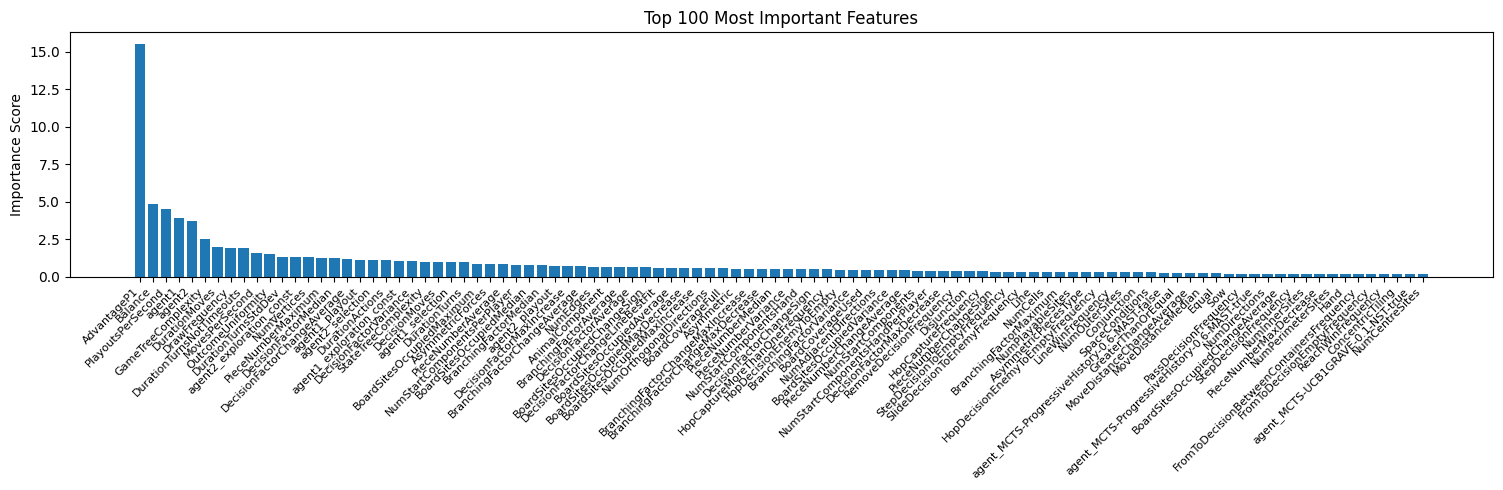

Fold 5 - RMSE: 0.4013013163894061
List of oof scores: [0.42137958427998606, 0.4411871527982296, 0.4330435187384083, 0.4374463004161349, 0.4013013163894061]
Average oof score: 0.426871574524433


In [11]:
# call the function
trained_models1, oof1, oof_scores1, importance_df1 = train_models(
    df_train, 
    numerical_cols, 
    categorical_cols, 
    text_cols=text_cols,
    split_list=split1,
)
# save oof predictions
oof1.to_parquet(path_results / f'oof_catboost_{fs_type}_cv1.parquet', index=False)

# save feature importance
# importance_df1.to_csv(path_results / 'feat_importance_catboost_cv1.csv', index=False)

Fold 1


0:	learn: 0.6192711	test: 0.5325570	best: 0.5325570 (0)	total: 84.9ms	remaining: 4m 14s


50:	learn: 0.3950315	test: 0.4468126	best: 0.4468126 (50)	total: 4.57s	remaining: 4m 24s


100:	learn: 0.3504762	test: 0.4307212	best: 0.4307212 (100)	total: 9.34s	remaining: 4m 28s


150:	learn: 0.3254006	test: 0.4234677	best: 0.4234677 (150)	total: 14s	remaining: 4m 23s


200:	learn: 0.3105240	test: 0.4204551	best: 0.4204551 (200)	total: 18.6s	remaining: 4m 19s


250:	learn: 0.2991476	test: 0.4186830	best: 0.4186830 (250)	total: 23.3s	remaining: 4m 15s


300:	learn: 0.2885470	test: 0.4172067	best: 0.4171313 (298)	total: 27.9s	remaining: 4m 10s


350:	learn: 0.2803701	test: 0.4161605	best: 0.4161083 (349)	total: 32.5s	remaining: 4m 4s


400:	learn: 0.2726514	test: 0.4145811	best: 0.4145811 (400)	total: 37.1s	remaining: 4m


450:	learn: 0.2661411	test: 0.4140452	best: 0.4140452 (450)	total: 41.8s	remaining: 3m 56s


500:	learn: 0.2601289	test: 0.4137567	best: 0.4136937 (475)	total: 46.4s	remaining: 3m 51s


550:	learn: 0.2551184	test: 0.4128663	best: 0.4128663 (550)	total: 51.1s	remaining: 3m 47s


600:	learn: 0.2505783	test: 0.4122881	best: 0.4122873 (599)	total: 55.8s	remaining: 3m 42s


650:	learn: 0.2463194	test: 0.4118658	best: 0.4117824 (644)	total: 1m	remaining: 3m 38s


700:	learn: 0.2425582	test: 0.4113771	best: 0.4113771 (700)	total: 1m 5s	remaining: 3m 33s


750:	learn: 0.2387574	test: 0.4113717	best: 0.4113670 (706)	total: 1m 9s	remaining: 3m 29s


800:	learn: 0.2355155	test: 0.4113162	best: 0.4112640 (788)	total: 1m 14s	remaining: 3m 24s


850:	learn: 0.2324035	test: 0.4109711	best: 0.4109711 (850)	total: 1m 19s	remaining: 3m 20s


900:	learn: 0.2294533	test: 0.4105897	best: 0.4105897 (900)	total: 1m 24s	remaining: 3m 15s


950:	learn: 0.2265188	test: 0.4103471	best: 0.4103470 (939)	total: 1m 28s	remaining: 3m 11s


1000:	learn: 0.2237544	test: 0.4101635	best: 0.4101635 (1000)	total: 1m 33s	remaining: 3m 6s


1050:	learn: 0.2211122	test: 0.4101027	best: 0.4100895 (1049)	total: 1m 38s	remaining: 3m 2s


1100:	learn: 0.2186674	test: 0.4099345	best: 0.4099308 (1098)	total: 1m 42s	remaining: 2m 57s


1150:	learn: 0.2161518	test: 0.4098253	best: 0.4098253 (1150)	total: 1m 47s	remaining: 2m 52s


1200:	learn: 0.2139251	test: 0.4097233	best: 0.4097072 (1195)	total: 1m 52s	remaining: 2m 48s


1250:	learn: 0.2118080	test: 0.4095345	best: 0.4095181 (1241)	total: 1m 57s	remaining: 2m 43s


1300:	learn: 0.2098413	test: 0.4095856	best: 0.4095181 (1241)	total: 2m 1s	remaining: 2m 39s


1350:	learn: 0.2078197	test: 0.4094714	best: 0.4094594 (1349)	total: 2m 6s	remaining: 2m 34s


1400:	learn: 0.2059359	test: 0.4093230	best: 0.4093230 (1400)	total: 2m 11s	remaining: 2m 29s


1450:	learn: 0.2040202	test: 0.4091732	best: 0.4091732 (1450)	total: 2m 15s	remaining: 2m 25s


1500:	learn: 0.2021940	test: 0.4089732	best: 0.4089732 (1500)	total: 2m 20s	remaining: 2m 20s


1550:	learn: 0.2004086	test: 0.4089291	best: 0.4088972 (1514)	total: 2m 25s	remaining: 2m 15s


1600:	learn: 0.1987505	test: 0.4089362	best: 0.4088972 (1514)	total: 2m 29s	remaining: 2m 11s


1650:	learn: 0.1971132	test: 0.4089293	best: 0.4088972 (1514)	total: 2m 34s	remaining: 2m 6s


1700:	learn: 0.1954187	test: 0.4089409	best: 0.4088972 (1514)	total: 2m 39s	remaining: 2m 1s


1750:	learn: 0.1938122	test: 0.4089035	best: 0.4088972 (1514)	total: 2m 44s	remaining: 1m 57s


1800:	learn: 0.1922048	test: 0.4087699	best: 0.4087699 (1800)	total: 2m 48s	remaining: 1m 52s


1850:	learn: 0.1905877	test: 0.4088065	best: 0.4087650 (1822)	total: 2m 53s	remaining: 1m 47s


1900:	learn: 0.1890997	test: 0.4087362	best: 0.4087362 (1900)	total: 2m 58s	remaining: 1m 43s


1950:	learn: 0.1878059	test: 0.4087774	best: 0.4087233 (1919)	total: 3m 3s	remaining: 1m 38s


2000:	learn: 0.1863276	test: 0.4087604	best: 0.4087192 (1974)	total: 3m 7s	remaining: 1m 33s


2050:	learn: 0.1847861	test: 0.4087821	best: 0.4087192 (1974)	total: 3m 12s	remaining: 1m 29s


2100:	learn: 0.1833951	test: 0.4087114	best: 0.4086938 (2094)	total: 3m 17s	remaining: 1m 24s


2150:	learn: 0.1820428	test: 0.4085429	best: 0.4085429 (2150)	total: 3m 22s	remaining: 1m 19s


2200:	learn: 0.1807412	test: 0.4084950	best: 0.4084869 (2196)	total: 3m 26s	remaining: 1m 15s


2250:	learn: 0.1793544	test: 0.4084604	best: 0.4084456 (2242)	total: 3m 31s	remaining: 1m 10s


2300:	learn: 0.1780878	test: 0.4084120	best: 0.4084120 (2300)	total: 3m 36s	remaining: 1m 5s


2350:	learn: 0.1767612	test: 0.4084120	best: 0.4083505 (2342)	total: 3m 40s	remaining: 1m 1s


2400:	learn: 0.1755686	test: 0.4084082	best: 0.4083505 (2342)	total: 3m 45s	remaining: 56.3s


2450:	learn: 0.1742924	test: 0.4083716	best: 0.4083505 (2342)	total: 3m 50s	remaining: 51.6s


2500:	learn: 0.1731033	test: 0.4083491	best: 0.4083284 (2490)	total: 3m 55s	remaining: 46.9s


2550:	learn: 0.1718722	test: 0.4083887	best: 0.4083284 (2490)	total: 3m 59s	remaining: 42.2s


2600:	learn: 0.1707295	test: 0.4083708	best: 0.4083284 (2490)	total: 4m 4s	remaining: 37.5s


2650:	learn: 0.1696259	test: 0.4083461	best: 0.4083284 (2490)	total: 4m 9s	remaining: 32.8s


2700:	learn: 0.1684569	test: 0.4083671	best: 0.4083113 (2662)	total: 4m 13s	remaining: 28.1s


2750:	learn: 0.1672495	test: 0.4084115	best: 0.4083113 (2662)	total: 4m 18s	remaining: 23.4s


2800:	learn: 0.1661589	test: 0.4084043	best: 0.4083113 (2662)	total: 4m 23s	remaining: 18.7s


2850:	learn: 0.1650308	test: 0.4084326	best: 0.4083113 (2662)	total: 4m 28s	remaining: 14s


2900:	learn: 0.1639277	test: 0.4083814	best: 0.4083113 (2662)	total: 4m 32s	remaining: 9.31s


2950:	learn: 0.1627893	test: 0.4084039	best: 0.4083113 (2662)	total: 4m 37s	remaining: 4.61s


2999:	learn: 0.1617918	test: 0.4084122	best: 0.4083113 (2662)	total: 4m 42s	remaining: 0us

bestTest = 0.408311284
bestIteration = 2662

Shrink model to first 2663 iterations.


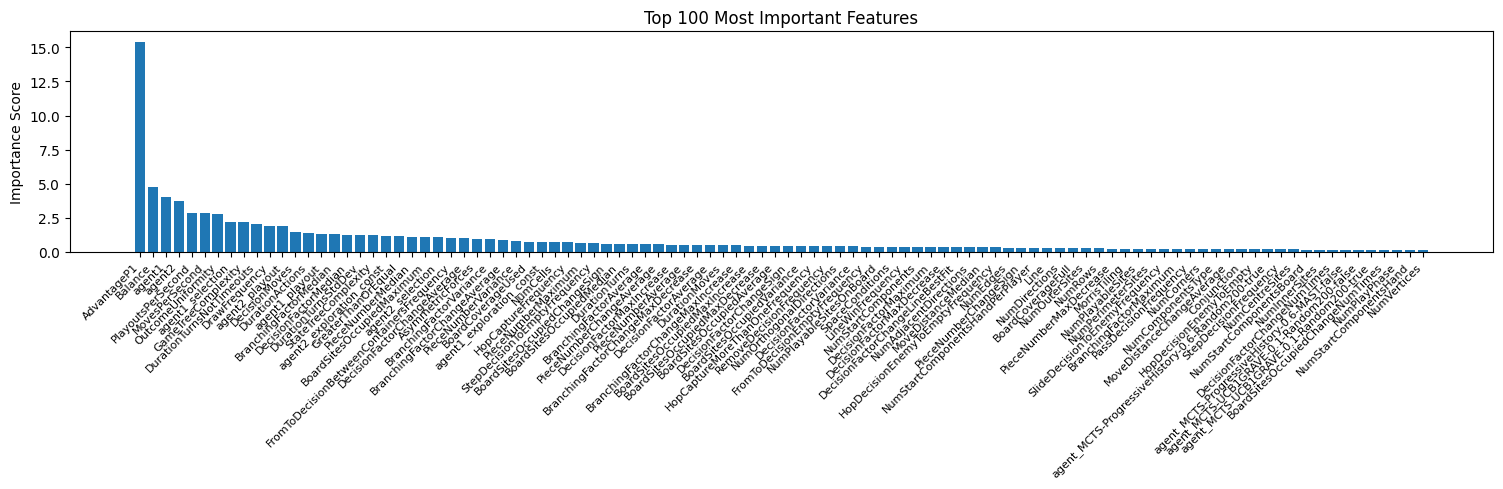

Fold 1 - RMSE: 0.4080107167385298
Fold 2


0:	learn: 0.6137783	test: 0.5368700	best: 0.5368700 (0)	total: 84.1ms	remaining: 4m 12s


50:	learn: 0.3907777	test: 0.4225293	best: 0.4225293 (50)	total: 4.63s	remaining: 4m 27s


100:	learn: 0.3496403	test: 0.4111142	best: 0.4111142 (100)	total: 9.39s	remaining: 4m 29s


150:	learn: 0.3252714	test: 0.4048388	best: 0.4048388 (150)	total: 14.1s	remaining: 4m 26s


200:	learn: 0.3100074	test: 0.4018347	best: 0.4018347 (200)	total: 18.9s	remaining: 4m 23s


250:	learn: 0.2973141	test: 0.4007989	best: 0.4007989 (250)	total: 23.7s	remaining: 4m 19s


300:	learn: 0.2874841	test: 0.3995503	best: 0.3995503 (300)	total: 28.4s	remaining: 4m 14s


350:	learn: 0.2788832	test: 0.3988416	best: 0.3985621 (337)	total: 33.1s	remaining: 4m 10s


400:	learn: 0.2716716	test: 0.3980302	best: 0.3980302 (400)	total: 37.9s	remaining: 4m 5s


450:	learn: 0.2657367	test: 0.3971804	best: 0.3971804 (450)	total: 42.7s	remaining: 4m 1s


500:	learn: 0.2598519	test: 0.3966845	best: 0.3966845 (500)	total: 47.5s	remaining: 3m 57s


550:	learn: 0.2548524	test: 0.3962173	best: 0.3961905 (549)	total: 52.3s	remaining: 3m 52s


600:	learn: 0.2499487	test: 0.3958247	best: 0.3957922 (597)	total: 57.1s	remaining: 3m 48s


650:	learn: 0.2456841	test: 0.3956023	best: 0.3955251 (635)	total: 1m 1s	remaining: 3m 43s


700:	learn: 0.2414910	test: 0.3952907	best: 0.3952907 (700)	total: 1m 6s	remaining: 3m 38s


750:	learn: 0.2377956	test: 0.3950731	best: 0.3950437 (729)	total: 1m 11s	remaining: 3m 33s


800:	learn: 0.2341752	test: 0.3952172	best: 0.3950437 (729)	total: 1m 16s	remaining: 3m 29s


850:	learn: 0.2311231	test: 0.3953455	best: 0.3950437 (729)	total: 1m 20s	remaining: 3m 24s


900:	learn: 0.2281165	test: 0.3953930	best: 0.3950437 (729)	total: 1m 25s	remaining: 3m 19s


950:	learn: 0.2254488	test: 0.3954064	best: 0.3950437 (729)	total: 1m 30s	remaining: 3m 14s


1000:	learn: 0.2227688	test: 0.3952188	best: 0.3950437 (729)	total: 1m 35s	remaining: 3m 10s


1050:	learn: 0.2201618	test: 0.3952338	best: 0.3950437 (729)	total: 1m 39s	remaining: 3m 5s


1100:	learn: 0.2180239	test: 0.3953472	best: 0.3950437 (729)	total: 1m 44s	remaining: 3m


1150:	learn: 0.2156966	test: 0.3955726	best: 0.3950437 (729)	total: 1m 49s	remaining: 2m 55s


1200:	learn: 0.2135753	test: 0.3956870	best: 0.3950437 (729)	total: 1m 54s	remaining: 2m 50s


1250:	learn: 0.2115643	test: 0.3958233	best: 0.3950437 (729)	total: 1m 58s	remaining: 2m 46s


1300:	learn: 0.2096470	test: 0.3957963	best: 0.3950437 (729)	total: 2m 3s	remaining: 2m 41s


1350:	learn: 0.2076228	test: 0.3958337	best: 0.3950437 (729)	total: 2m 8s	remaining: 2m 36s


1400:	learn: 0.2056605	test: 0.3958682	best: 0.3950437 (729)	total: 2m 13s	remaining: 2m 31s


1450:	learn: 0.2037681	test: 0.3959385	best: 0.3950437 (729)	total: 2m 17s	remaining: 2m 27s


1500:	learn: 0.2018620	test: 0.3960816	best: 0.3950437 (729)	total: 2m 22s	remaining: 2m 22s


1550:	learn: 0.2000807	test: 0.3960803	best: 0.3950437 (729)	total: 2m 27s	remaining: 2m 17s


1600:	learn: 0.1982949	test: 0.3961920	best: 0.3950437 (729)	total: 2m 32s	remaining: 2m 12s


1650:	learn: 0.1964739	test: 0.3961548	best: 0.3950437 (729)	total: 2m 36s	remaining: 2m 8s


1700:	learn: 0.1948046	test: 0.3961536	best: 0.3950437 (729)	total: 2m 41s	remaining: 2m 3s


1750:	learn: 0.1932730	test: 0.3961473	best: 0.3950437 (729)	total: 2m 46s	remaining: 1m 58s


1800:	learn: 0.1917629	test: 0.3960649	best: 0.3950437 (729)	total: 2m 51s	remaining: 1m 53s


1850:	learn: 0.1902609	test: 0.3960736	best: 0.3950437 (729)	total: 2m 55s	remaining: 1m 49s


1900:	learn: 0.1889438	test: 0.3961284	best: 0.3950437 (729)	total: 3m	remaining: 1m 44s


1950:	learn: 0.1874385	test: 0.3961643	best: 0.3950437 (729)	total: 3m 5s	remaining: 1m 39s


2000:	learn: 0.1859136	test: 0.3962806	best: 0.3950437 (729)	total: 3m 10s	remaining: 1m 34s


2050:	learn: 0.1845010	test: 0.3962805	best: 0.3950437 (729)	total: 3m 14s	remaining: 1m 30s


2100:	learn: 0.1831325	test: 0.3962742	best: 0.3950437 (729)	total: 3m 19s	remaining: 1m 25s


2150:	learn: 0.1817471	test: 0.3963295	best: 0.3950437 (729)	total: 3m 24s	remaining: 1m 20s


2200:	learn: 0.1804001	test: 0.3963219	best: 0.3950437 (729)	total: 3m 29s	remaining: 1m 15s


2250:	learn: 0.1791266	test: 0.3963509	best: 0.3950437 (729)	total: 3m 34s	remaining: 1m 11s


2300:	learn: 0.1777521	test: 0.3963695	best: 0.3950437 (729)	total: 3m 38s	remaining: 1m 6s


2350:	learn: 0.1763487	test: 0.3964274	best: 0.3950437 (729)	total: 3m 43s	remaining: 1m 1s


2400:	learn: 0.1750627	test: 0.3965025	best: 0.3950437 (729)	total: 3m 48s	remaining: 57s


2450:	learn: 0.1739400	test: 0.3965090	best: 0.3950437 (729)	total: 3m 53s	remaining: 52.2s


2500:	learn: 0.1726235	test: 0.3965880	best: 0.3950437 (729)	total: 3m 57s	remaining: 47.4s


2550:	learn: 0.1714866	test: 0.3966080	best: 0.3950437 (729)	total: 4m 2s	remaining: 42.7s


2600:	learn: 0.1704081	test: 0.3965671	best: 0.3950437 (729)	total: 4m 7s	remaining: 38s


2650:	learn: 0.1692996	test: 0.3966014	best: 0.3950437 (729)	total: 4m 12s	remaining: 33.2s


2700:	learn: 0.1681179	test: 0.3966772	best: 0.3950437 (729)	total: 4m 16s	remaining: 28.4s


2750:	learn: 0.1669163	test: 0.3967333	best: 0.3950437 (729)	total: 4m 21s	remaining: 23.7s


2800:	learn: 0.1658241	test: 0.3966982	best: 0.3950437 (729)	total: 4m 26s	remaining: 18.9s


2850:	learn: 0.1647522	test: 0.3967343	best: 0.3950437 (729)	total: 4m 31s	remaining: 14.2s


2900:	learn: 0.1636861	test: 0.3966916	best: 0.3950437 (729)	total: 4m 36s	remaining: 9.42s


2950:	learn: 0.1625731	test: 0.3967478	best: 0.3950437 (729)	total: 4m 40s	remaining: 4.66s


2999:	learn: 0.1616085	test: 0.3967621	best: 0.3950437 (729)	total: 4m 45s	remaining: 0us

bestTest = 0.395043742
bestIteration = 729

Shrink model to first 730 iterations.


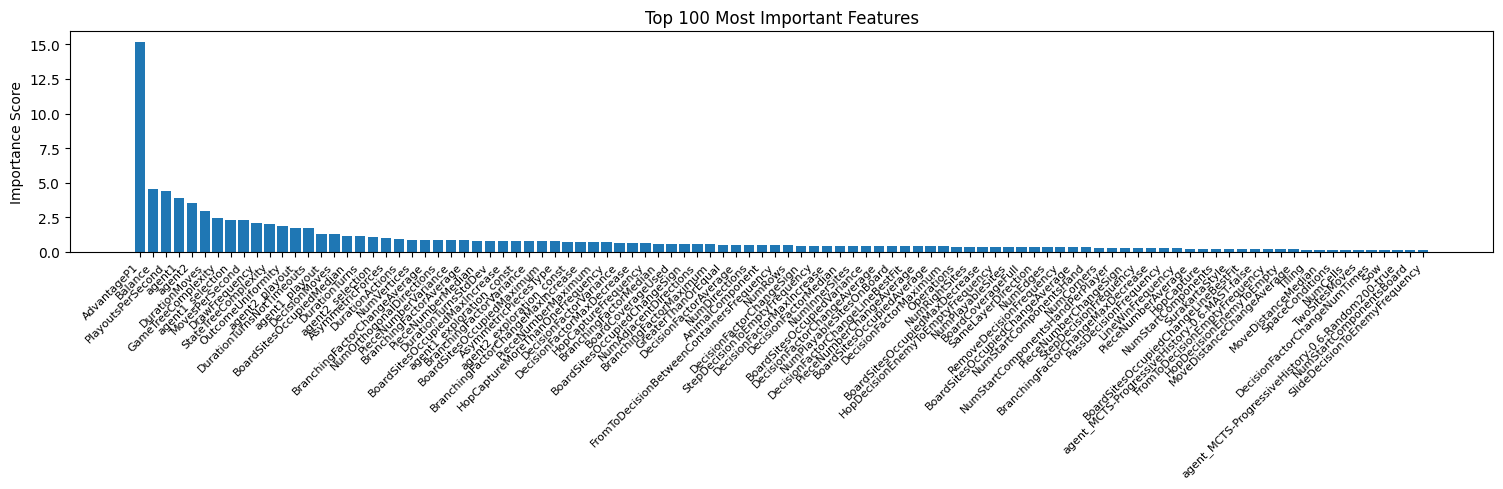

Fold 2 - RMSE: 0.39446768847619645
Fold 3


0:	learn: 0.6020635	test: 0.6078541	best: 0.6078541 (0)	total: 84.1ms	remaining: 4m 12s


50:	learn: 0.3840731	test: 0.4794515	best: 0.4794515 (50)	total: 4.62s	remaining: 4m 27s


100:	learn: 0.3444421	test: 0.4563073	best: 0.4563073 (100)	total: 9.38s	remaining: 4m 29s


150:	learn: 0.3196117	test: 0.4471036	best: 0.4471036 (150)	total: 14.1s	remaining: 4m 25s


200:	learn: 0.3037816	test: 0.4414195	best: 0.4414195 (200)	total: 18.8s	remaining: 4m 21s


250:	learn: 0.2922371	test: 0.4386847	best: 0.4386560 (249)	total: 23.4s	remaining: 4m 16s


300:	learn: 0.2836281	test: 0.4368325	best: 0.4368325 (300)	total: 28.1s	remaining: 4m 12s


350:	learn: 0.2755999	test: 0.4351672	best: 0.4351672 (350)	total: 32.9s	remaining: 4m 8s


400:	learn: 0.2686777	test: 0.4337836	best: 0.4337836 (400)	total: 37.7s	remaining: 4m 4s


450:	learn: 0.2629571	test: 0.4329957	best: 0.4329957 (450)	total: 42.4s	remaining: 3m 59s


500:	learn: 0.2576283	test: 0.4321361	best: 0.4320833 (490)	total: 47.2s	remaining: 3m 55s


550:	learn: 0.2527109	test: 0.4314436	best: 0.4314426 (549)	total: 52s	remaining: 3m 50s


600:	learn: 0.2483944	test: 0.4308872	best: 0.4308618 (593)	total: 56.7s	remaining: 3m 46s


650:	learn: 0.2444131	test: 0.4303730	best: 0.4303610 (641)	total: 1m 1s	remaining: 3m 41s


700:	learn: 0.2406785	test: 0.4296430	best: 0.4296330 (699)	total: 1m 6s	remaining: 3m 37s


750:	learn: 0.2371435	test: 0.4294588	best: 0.4294569 (725)	total: 1m 11s	remaining: 3m 32s


800:	learn: 0.2338763	test: 0.4291951	best: 0.4291948 (799)	total: 1m 15s	remaining: 3m 28s


850:	learn: 0.2306403	test: 0.4289810	best: 0.4289742 (848)	total: 1m 20s	remaining: 3m 23s


900:	learn: 0.2280308	test: 0.4285917	best: 0.4285846 (896)	total: 1m 25s	remaining: 3m 18s


950:	learn: 0.2255674	test: 0.4282661	best: 0.4282661 (950)	total: 1m 30s	remaining: 3m 14s


1000:	learn: 0.2232833	test: 0.4280467	best: 0.4280211 (994)	total: 1m 35s	remaining: 3m 9s


1050:	learn: 0.2207774	test: 0.4277815	best: 0.4277812 (1048)	total: 1m 39s	remaining: 3m 4s


1100:	learn: 0.2183960	test: 0.4276362	best: 0.4276362 (1100)	total: 1m 44s	remaining: 3m


1150:	learn: 0.2162343	test: 0.4275673	best: 0.4275193 (1141)	total: 1m 49s	remaining: 2m 55s


1200:	learn: 0.2142337	test: 0.4274201	best: 0.4274201 (1200)	total: 1m 54s	remaining: 2m 50s


1250:	learn: 0.2121463	test: 0.4270533	best: 0.4270533 (1250)	total: 1m 58s	remaining: 2m 46s


1300:	learn: 0.2101167	test: 0.4269117	best: 0.4269040 (1299)	total: 2m 3s	remaining: 2m 41s


1350:	learn: 0.2078898	test: 0.4268175	best: 0.4267921 (1334)	total: 2m 8s	remaining: 2m 36s


1400:	learn: 0.2060746	test: 0.4266995	best: 0.4266995 (1400)	total: 2m 13s	remaining: 2m 32s


1450:	learn: 0.2042538	test: 0.4266208	best: 0.4266208 (1450)	total: 2m 17s	remaining: 2m 27s


1500:	learn: 0.2026268	test: 0.4265571	best: 0.4265571 (1500)	total: 2m 22s	remaining: 2m 22s


1550:	learn: 0.2009684	test: 0.4264662	best: 0.4264529 (1546)	total: 2m 27s	remaining: 2m 17s


1600:	learn: 0.1992009	test: 0.4263078	best: 0.4263078 (1600)	total: 2m 32s	remaining: 2m 13s


1650:	learn: 0.1977128	test: 0.4261753	best: 0.4261753 (1650)	total: 2m 37s	remaining: 2m 8s


1700:	learn: 0.1960427	test: 0.4261474	best: 0.4261247 (1668)	total: 2m 42s	remaining: 2m 3s


1750:	learn: 0.1944224	test: 0.4260622	best: 0.4260622 (1750)	total: 2m 46s	remaining: 1m 59s


1800:	learn: 0.1927996	test: 0.4259683	best: 0.4259481 (1797)	total: 2m 51s	remaining: 1m 54s


1850:	learn: 0.1914428	test: 0.4259184	best: 0.4259094 (1845)	total: 2m 56s	remaining: 1m 49s


1900:	learn: 0.1899816	test: 0.4258403	best: 0.4258359 (1899)	total: 3m 1s	remaining: 1m 44s


1950:	learn: 0.1885465	test: 0.4257951	best: 0.4257780 (1941)	total: 3m 6s	remaining: 1m 40s


2000:	learn: 0.1870790	test: 0.4256916	best: 0.4256916 (2000)	total: 3m 11s	remaining: 1m 35s


2050:	learn: 0.1856184	test: 0.4256536	best: 0.4256496 (2045)	total: 3m 15s	remaining: 1m 30s


2100:	learn: 0.1842133	test: 0.4255891	best: 0.4255891 (2100)	total: 3m 20s	remaining: 1m 25s


2150:	learn: 0.1829213	test: 0.4255929	best: 0.4255831 (2112)	total: 3m 25s	remaining: 1m 21s


2200:	learn: 0.1816208	test: 0.4255789	best: 0.4255608 (2171)	total: 3m 30s	remaining: 1m 16s


2250:	learn: 0.1803483	test: 0.4256294	best: 0.4255608 (2171)	total: 3m 35s	remaining: 1m 11s


2300:	learn: 0.1790665	test: 0.4256907	best: 0.4255608 (2171)	total: 3m 39s	remaining: 1m 6s


2350:	learn: 0.1778126	test: 0.4256953	best: 0.4255608 (2171)	total: 3m 44s	remaining: 1m 2s


2400:	learn: 0.1765245	test: 0.4257007	best: 0.4255608 (2171)	total: 3m 49s	remaining: 57.2s


2450:	learn: 0.1753002	test: 0.4257450	best: 0.4255608 (2171)	total: 3m 54s	remaining: 52.5s


2500:	learn: 0.1742317	test: 0.4257255	best: 0.4255608 (2171)	total: 3m 59s	remaining: 47.7s


2550:	learn: 0.1729204	test: 0.4257500	best: 0.4255608 (2171)	total: 4m 3s	remaining: 42.9s


2600:	learn: 0.1716819	test: 0.4256736	best: 0.4255608 (2171)	total: 4m 8s	remaining: 38.1s


2650:	learn: 0.1706218	test: 0.4255853	best: 0.4255608 (2171)	total: 4m 13s	remaining: 33.3s


2700:	learn: 0.1695290	test: 0.4255722	best: 0.4255608 (2171)	total: 4m 18s	remaining: 28.6s


2750:	learn: 0.1684327	test: 0.4255587	best: 0.4255568 (2747)	total: 4m 22s	remaining: 23.8s


2800:	learn: 0.1673696	test: 0.4255670	best: 0.4255483 (2760)	total: 4m 27s	remaining: 19s


2850:	learn: 0.1662646	test: 0.4255319	best: 0.4255073 (2831)	total: 4m 32s	remaining: 14.2s


2900:	learn: 0.1652349	test: 0.4254958	best: 0.4254721 (2886)	total: 4m 37s	remaining: 9.47s


2950:	learn: 0.1642136	test: 0.4255272	best: 0.4254721 (2886)	total: 4m 42s	remaining: 4.69s


2999:	learn: 0.1632413	test: 0.4255291	best: 0.4254721 (2886)	total: 4m 47s	remaining: 0us

bestTest = 0.4254721172
bestIteration = 2886

Shrink model to first 2887 iterations.


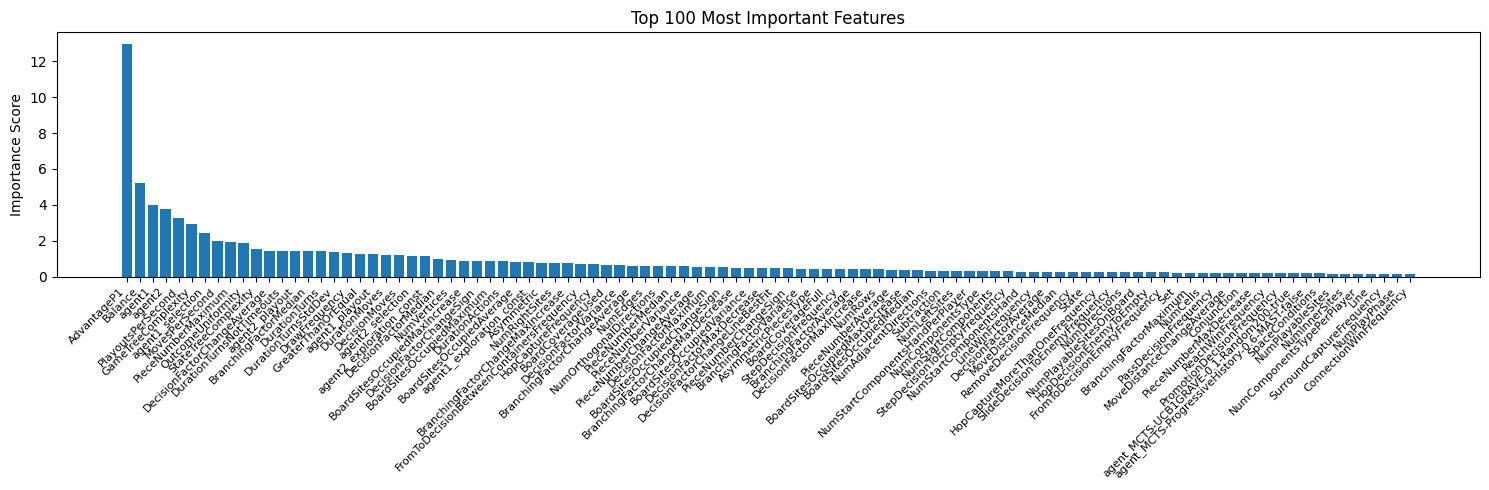

Fold 3 - RMSE: 0.4245453587509536
Fold 4


0:	learn: 0.6030752	test: 0.5955150	best: 0.5955150 (0)	total: 84.9ms	remaining: 4m 14s


50:	learn: 0.3866280	test: 0.4802588	best: 0.4801446 (49)	total: 4.62s	remaining: 4m 27s


100:	learn: 0.3503567	test: 0.4637597	best: 0.4637597 (100)	total: 9.46s	remaining: 4m 31s


150:	learn: 0.3285557	test: 0.4569123	best: 0.4569123 (150)	total: 14.3s	remaining: 4m 29s


200:	learn: 0.3126967	test: 0.4526936	best: 0.4526936 (200)	total: 19.2s	remaining: 4m 26s


250:	learn: 0.3007999	test: 0.4508186	best: 0.4507890 (244)	total: 24s	remaining: 4m 22s


300:	learn: 0.2910119	test: 0.4491899	best: 0.4491899 (300)	total: 28.8s	remaining: 4m 18s


350:	learn: 0.2821169	test: 0.4475238	best: 0.4475238 (350)	total: 33.6s	remaining: 4m 13s


400:	learn: 0.2752604	test: 0.4463139	best: 0.4463139 (400)	total: 38.3s	remaining: 4m 8s


450:	learn: 0.2690317	test: 0.4455770	best: 0.4455770 (450)	total: 43.1s	remaining: 4m 3s


500:	learn: 0.2636911	test: 0.4452861	best: 0.4452861 (500)	total: 47.9s	remaining: 3m 59s


550:	learn: 0.2585243	test: 0.4444165	best: 0.4444165 (550)	total: 52.8s	remaining: 3m 54s


600:	learn: 0.2541559	test: 0.4437480	best: 0.4437480 (600)	total: 57.7s	remaining: 3m 50s


650:	learn: 0.2503182	test: 0.4434213	best: 0.4434018 (647)	total: 1m 2s	remaining: 3m 46s


700:	learn: 0.2464502	test: 0.4428001	best: 0.4428001 (700)	total: 1m 7s	remaining: 3m 41s


750:	learn: 0.2428681	test: 0.4424214	best: 0.4424214 (750)	total: 1m 12s	remaining: 3m 36s


800:	learn: 0.2397053	test: 0.4422439	best: 0.4422220 (796)	total: 1m 17s	remaining: 3m 31s


850:	learn: 0.2364174	test: 0.4419547	best: 0.4419547 (850)	total: 1m 21s	remaining: 3m 26s


900:	learn: 0.2335753	test: 0.4417882	best: 0.4417694 (899)	total: 1m 26s	remaining: 3m 22s


950:	learn: 0.2307141	test: 0.4414976	best: 0.4414621 (949)	total: 1m 31s	remaining: 3m 17s


1000:	learn: 0.2281413	test: 0.4414788	best: 0.4414582 (969)	total: 1m 36s	remaining: 3m 12s


1050:	learn: 0.2255276	test: 0.4413514	best: 0.4412810 (1044)	total: 1m 41s	remaining: 3m 7s


1100:	learn: 0.2230794	test: 0.4411943	best: 0.4411745 (1089)	total: 1m 45s	remaining: 3m 2s


1150:	learn: 0.2207186	test: 0.4409791	best: 0.4409791 (1150)	total: 1m 50s	remaining: 2m 57s


1200:	learn: 0.2185139	test: 0.4407360	best: 0.4407023 (1198)	total: 1m 55s	remaining: 2m 53s


1250:	learn: 0.2163784	test: 0.4406773	best: 0.4406773 (1250)	total: 2m	remaining: 2m 48s


1300:	learn: 0.2143462	test: 0.4405552	best: 0.4405542 (1299)	total: 2m 5s	remaining: 2m 43s


1350:	learn: 0.2124597	test: 0.4404969	best: 0.4404736 (1327)	total: 2m 10s	remaining: 2m 38s


1400:	learn: 0.2104422	test: 0.4404143	best: 0.4404143 (1400)	total: 2m 14s	remaining: 2m 34s


1450:	learn: 0.2085438	test: 0.4404467	best: 0.4403213 (1426)	total: 2m 19s	remaining: 2m 29s


1500:	learn: 0.2066470	test: 0.4403571	best: 0.4403213 (1426)	total: 2m 24s	remaining: 2m 24s


1550:	learn: 0.2049522	test: 0.4403817	best: 0.4403213 (1426)	total: 2m 29s	remaining: 2m 19s


1600:	learn: 0.2032040	test: 0.4404389	best: 0.4403213 (1426)	total: 2m 34s	remaining: 2m 14s


1650:	learn: 0.2015813	test: 0.4403229	best: 0.4403213 (1426)	total: 2m 39s	remaining: 2m 10s


1700:	learn: 0.1999452	test: 0.4403351	best: 0.4402977 (1695)	total: 2m 44s	remaining: 2m 5s


1750:	learn: 0.1982399	test: 0.4401844	best: 0.4401729 (1748)	total: 2m 48s	remaining: 2m


1800:	learn: 0.1966031	test: 0.4401248	best: 0.4401205 (1799)	total: 2m 53s	remaining: 1m 55s


1850:	learn: 0.1950433	test: 0.4401819	best: 0.4401205 (1799)	total: 2m 58s	remaining: 1m 50s


1900:	learn: 0.1934202	test: 0.4400120	best: 0.4399978 (1878)	total: 3m 3s	remaining: 1m 45s


1950:	learn: 0.1920207	test: 0.4400469	best: 0.4399978 (1878)	total: 3m 8s	remaining: 1m 41s


2000:	learn: 0.1904965	test: 0.4399015	best: 0.4399015 (2000)	total: 3m 12s	remaining: 1m 36s


2050:	learn: 0.1891438	test: 0.4399056	best: 0.4398878 (2045)	total: 3m 17s	remaining: 1m 31s


2100:	learn: 0.1878124	test: 0.4398952	best: 0.4398626 (2067)	total: 3m 22s	remaining: 1m 26s


2150:	learn: 0.1864109	test: 0.4399158	best: 0.4398626 (2067)	total: 3m 27s	remaining: 1m 21s


2200:	learn: 0.1850682	test: 0.4399268	best: 0.4398626 (2067)	total: 3m 32s	remaining: 1m 17s


2250:	learn: 0.1838438	test: 0.4398896	best: 0.4398604 (2224)	total: 3m 37s	remaining: 1m 12s


2300:	learn: 0.1825205	test: 0.4399420	best: 0.4398604 (2224)	total: 3m 42s	remaining: 1m 7s


2350:	learn: 0.1812437	test: 0.4398869	best: 0.4398604 (2224)	total: 3m 46s	remaining: 1m 2s


2400:	learn: 0.1799238	test: 0.4398727	best: 0.4398365 (2391)	total: 3m 51s	remaining: 57.8s


2450:	learn: 0.1787426	test: 0.4398235	best: 0.4398001 (2442)	total: 3m 56s	remaining: 53s


2500:	learn: 0.1775544	test: 0.4397306	best: 0.4397278 (2497)	total: 4m 1s	remaining: 48.2s


2550:	learn: 0.1764105	test: 0.4396848	best: 0.4396720 (2539)	total: 4m 6s	remaining: 43.3s


2600:	learn: 0.1751844	test: 0.4396644	best: 0.4396294 (2583)	total: 4m 11s	remaining: 38.5s


2650:	learn: 0.1740547	test: 0.4396221	best: 0.4395926 (2639)	total: 4m 16s	remaining: 33.7s


2700:	learn: 0.1729294	test: 0.4395767	best: 0.4395761 (2699)	total: 4m 20s	remaining: 28.9s


2750:	learn: 0.1718672	test: 0.4396224	best: 0.4395583 (2723)	total: 4m 25s	remaining: 24.1s


2800:	learn: 0.1708084	test: 0.4396284	best: 0.4395583 (2723)	total: 4m 30s	remaining: 19.2s


2850:	learn: 0.1696312	test: 0.4395685	best: 0.4395583 (2723)	total: 4m 35s	remaining: 14.4s


2900:	learn: 0.1686061	test: 0.4395529	best: 0.4395398 (2892)	total: 4m 40s	remaining: 9.57s


2950:	learn: 0.1675607	test: 0.4394620	best: 0.4394558 (2947)	total: 4m 45s	remaining: 4.74s


2999:	learn: 0.1665327	test: 0.4394688	best: 0.4394429 (2981)	total: 4m 50s	remaining: 0us

bestTest = 0.4394429265
bestIteration = 2981

Shrink model to first 2982 iterations.


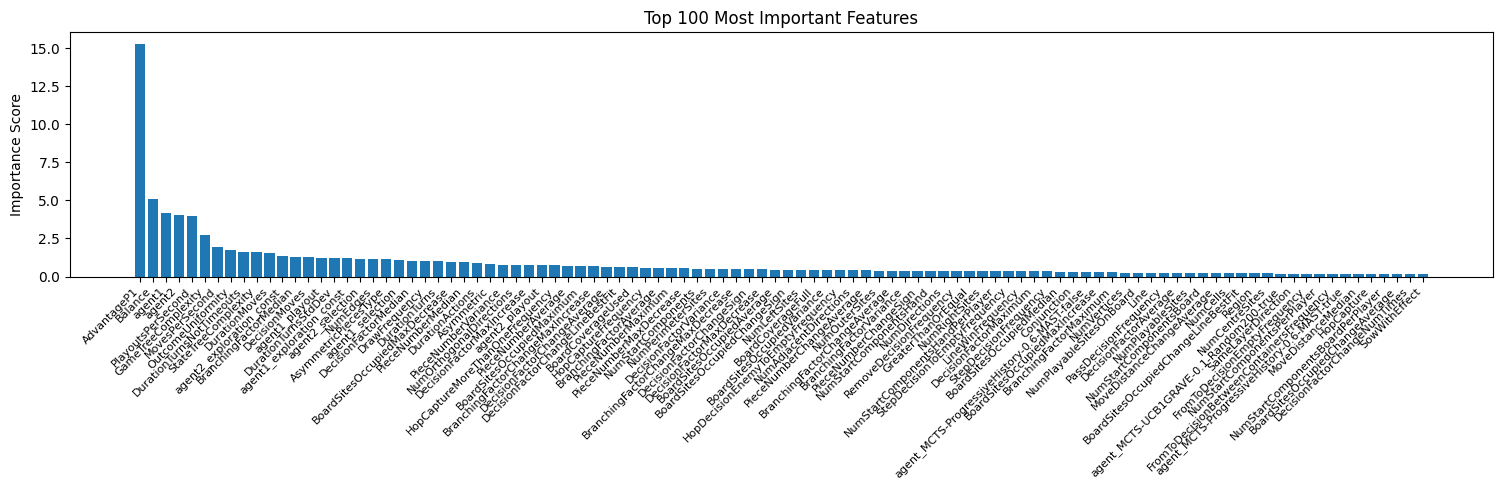

Fold 4 - RMSE: 0.4390683053495952
Fold 5


0:	learn: 0.6031260	test: 0.5866666	best: 0.5866666 (0)	total: 75.4ms	remaining: 3m 46s


50:	learn: 0.3830739	test: 0.4826662	best: 0.4826662 (50)	total: 4.5s	remaining: 4m 20s


100:	learn: 0.3456228	test: 0.4613532	best: 0.4613532 (100)	total: 9.31s	remaining: 4m 27s


150:	learn: 0.3238692	test: 0.4532139	best: 0.4532139 (150)	total: 14s	remaining: 4m 24s


200:	learn: 0.3069223	test: 0.4481260	best: 0.4481260 (200)	total: 18.7s	remaining: 4m 20s


250:	learn: 0.2961047	test: 0.4451985	best: 0.4451985 (250)	total: 23.4s	remaining: 4m 15s


300:	learn: 0.2864708	test: 0.4426040	best: 0.4426040 (300)	total: 28.2s	remaining: 4m 12s


350:	learn: 0.2784192	test: 0.4409778	best: 0.4409778 (350)	total: 32.9s	remaining: 4m 8s


400:	learn: 0.2719139	test: 0.4402349	best: 0.4402349 (400)	total: 37.6s	remaining: 4m 3s


450:	learn: 0.2658135	test: 0.4394358	best: 0.4394358 (450)	total: 42.3s	remaining: 3m 59s


500:	learn: 0.2607601	test: 0.4390266	best: 0.4390052 (499)	total: 47.2s	remaining: 3m 55s


550:	learn: 0.2556612	test: 0.4382753	best: 0.4382753 (550)	total: 51.8s	remaining: 3m 50s


600:	learn: 0.2513368	test: 0.4375122	best: 0.4375122 (600)	total: 56.6s	remaining: 3m 46s


650:	learn: 0.2473972	test: 0.4371382	best: 0.4370207 (639)	total: 1m 1s	remaining: 3m 41s


700:	learn: 0.2435948	test: 0.4368299	best: 0.4368299 (700)	total: 1m 6s	remaining: 3m 37s


750:	learn: 0.2400338	test: 0.4364144	best: 0.4363506 (747)	total: 1m 11s	remaining: 3m 32s


800:	learn: 0.2367290	test: 0.4362903	best: 0.4362892 (768)	total: 1m 15s	remaining: 3m 28s


850:	learn: 0.2336281	test: 0.4359415	best: 0.4359415 (850)	total: 1m 20s	remaining: 3m 23s


900:	learn: 0.2307000	test: 0.4358498	best: 0.4358498 (900)	total: 1m 25s	remaining: 3m 18s


950:	learn: 0.2279299	test: 0.4357496	best: 0.4357203 (931)	total: 1m 30s	remaining: 3m 14s


1000:	learn: 0.2255581	test: 0.4354008	best: 0.4353532 (984)	total: 1m 34s	remaining: 3m 9s


1050:	learn: 0.2230650	test: 0.4353079	best: 0.4352289 (1032)	total: 1m 39s	remaining: 3m 4s


1100:	learn: 0.2206287	test: 0.4350524	best: 0.4350524 (1100)	total: 1m 44s	remaining: 3m


1150:	learn: 0.2183355	test: 0.4349166	best: 0.4349166 (1150)	total: 1m 49s	remaining: 2m 55s


1200:	learn: 0.2163055	test: 0.4347968	best: 0.4347468 (1193)	total: 1m 54s	remaining: 2m 50s


1250:	learn: 0.2142102	test: 0.4348019	best: 0.4347258 (1226)	total: 1m 58s	remaining: 2m 46s


1300:	learn: 0.2120689	test: 0.4345974	best: 0.4345974 (1300)	total: 2m 3s	remaining: 2m 41s


1350:	learn: 0.2101082	test: 0.4345733	best: 0.4345138 (1324)	total: 2m 8s	remaining: 2m 36s


1400:	learn: 0.2082708	test: 0.4345362	best: 0.4344791 (1362)	total: 2m 13s	remaining: 2m 31s


1450:	learn: 0.2064052	test: 0.4343198	best: 0.4343198 (1450)	total: 2m 17s	remaining: 2m 27s


1500:	learn: 0.2046597	test: 0.4342720	best: 0.4342720 (1500)	total: 2m 22s	remaining: 2m 22s


1550:	learn: 0.2028981	test: 0.4342184	best: 0.4342132 (1533)	total: 2m 27s	remaining: 2m 17s


1600:	learn: 0.2010737	test: 0.4341031	best: 0.4340967 (1597)	total: 2m 32s	remaining: 2m 13s


1650:	learn: 0.1993923	test: 0.4341136	best: 0.4340469 (1630)	total: 2m 37s	remaining: 2m 8s


1700:	learn: 0.1977761	test: 0.4341124	best: 0.4340469 (1630)	total: 2m 41s	remaining: 2m 3s


1750:	learn: 0.1962085	test: 0.4340723	best: 0.4340469 (1630)	total: 2m 46s	remaining: 1m 58s


1800:	learn: 0.1944966	test: 0.4339502	best: 0.4339502 (1800)	total: 2m 51s	remaining: 1m 54s


1850:	learn: 0.1927741	test: 0.4339876	best: 0.4338967 (1811)	total: 2m 56s	remaining: 1m 49s


1900:	learn: 0.1912095	test: 0.4338785	best: 0.4338676 (1898)	total: 3m	remaining: 1m 44s


1950:	learn: 0.1897269	test: 0.4338814	best: 0.4338471 (1924)	total: 3m 5s	remaining: 1m 39s


2000:	learn: 0.1883313	test: 0.4338255	best: 0.4338232 (1999)	total: 3m 10s	remaining: 1m 35s


2050:	learn: 0.1868352	test: 0.4337988	best: 0.4337848 (2042)	total: 3m 15s	remaining: 1m 30s


2100:	learn: 0.1854350	test: 0.4337033	best: 0.4336955 (2089)	total: 3m 20s	remaining: 1m 25s


2150:	learn: 0.1840631	test: 0.4336926	best: 0.4336713 (2128)	total: 3m 25s	remaining: 1m 20s


2200:	learn: 0.1827653	test: 0.4337453	best: 0.4336713 (2128)	total: 3m 29s	remaining: 1m 16s


2250:	learn: 0.1815161	test: 0.4337103	best: 0.4336713 (2128)	total: 3m 34s	remaining: 1m 11s


2300:	learn: 0.1802192	test: 0.4336797	best: 0.4336713 (2128)	total: 3m 39s	remaining: 1m 6s


2350:	learn: 0.1788671	test: 0.4336289	best: 0.4336118 (2341)	total: 3m 44s	remaining: 1m 1s


2400:	learn: 0.1776701	test: 0.4335651	best: 0.4335651 (2400)	total: 3m 49s	remaining: 57.2s


2450:	learn: 0.1763901	test: 0.4335678	best: 0.4335138 (2428)	total: 3m 54s	remaining: 52.4s


2500:	learn: 0.1752151	test: 0.4336001	best: 0.4335138 (2428)	total: 3m 58s	remaining: 47.7s


2550:	learn: 0.1739669	test: 0.4337179	best: 0.4335138 (2428)	total: 4m 3s	remaining: 42.9s


2600:	learn: 0.1727919	test: 0.4336692	best: 0.4335138 (2428)	total: 4m 8s	remaining: 38.1s


2650:	learn: 0.1716236	test: 0.4336910	best: 0.4335138 (2428)	total: 4m 13s	remaining: 33.4s


2700:	learn: 0.1705560	test: 0.4336678	best: 0.4335138 (2428)	total: 4m 18s	remaining: 28.6s


2750:	learn: 0.1693827	test: 0.4336774	best: 0.4335138 (2428)	total: 4m 23s	remaining: 23.8s


2800:	learn: 0.1682855	test: 0.4337073	best: 0.4335138 (2428)	total: 4m 27s	remaining: 19s


2850:	learn: 0.1671708	test: 0.4337074	best: 0.4335138 (2428)	total: 4m 32s	remaining: 14.2s


2900:	learn: 0.1661356	test: 0.4336311	best: 0.4335138 (2428)	total: 4m 37s	remaining: 9.47s


2950:	learn: 0.1650530	test: 0.4336690	best: 0.4335138 (2428)	total: 4m 42s	remaining: 4.69s


2999:	learn: 0.1639318	test: 0.4336859	best: 0.4335138 (2428)	total: 4m 46s	remaining: 0us

bestTest = 0.4335137974
bestIteration = 2428

Shrink model to first 2429 iterations.


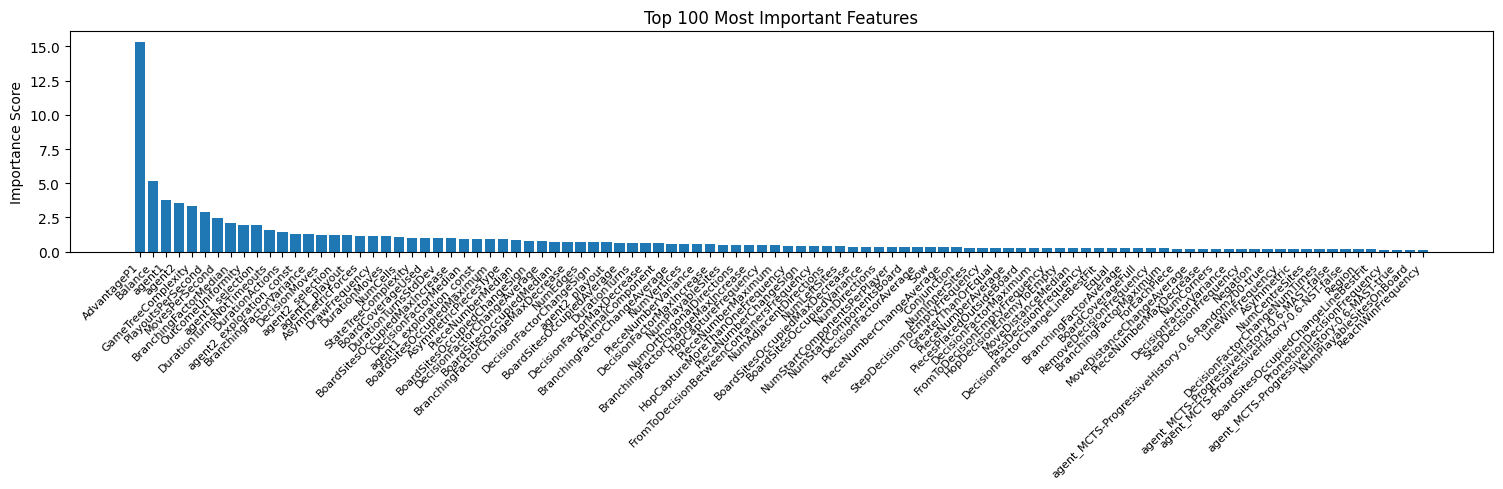

Fold 5 - RMSE: 0.4325887123492163
List of oof scores: [0.4080107167385298, 0.39446768847619645, 0.4245453587509536, 0.4390683053495952, 0.4325887123492163]
Average oof score: 0.41973615633289824


In [12]:
# call the function
trained_models2, oof2, oof_scores2, importance_df2 = train_models(
    df_train, 
    numerical_cols, 
    categorical_cols, 
    text_cols=text_cols,
    split_list=split2,
)
# save oof predictions
oof2.to_parquet(path_results / f'oof_catboost_{fs_type}_cv2.parquet', index=False)

Fold 1


0:	learn: 0.6092866	test: 0.5674538	best: 0.5674538 (0)	total: 73.8ms	remaining: 3m 41s


50:	learn: 0.3890791	test: 0.4629123	best: 0.4629123 (50)	total: 4.67s	remaining: 4m 30s


100:	learn: 0.3496271	test: 0.4465571	best: 0.4465571 (100)	total: 9.52s	remaining: 4m 33s


150:	learn: 0.3255370	test: 0.4393463	best: 0.4393463 (150)	total: 14.3s	remaining: 4m 29s


200:	learn: 0.3107474	test: 0.4366373	best: 0.4365317 (198)	total: 19s	remaining: 4m 24s


250:	learn: 0.2982310	test: 0.4350445	best: 0.4350445 (250)	total: 23.7s	remaining: 4m 20s


300:	learn: 0.2880778	test: 0.4332469	best: 0.4331854 (298)	total: 28.4s	remaining: 4m 14s


350:	learn: 0.2794494	test: 0.4319242	best: 0.4319242 (350)	total: 33.2s	remaining: 4m 10s


400:	learn: 0.2724700	test: 0.4305866	best: 0.4305866 (400)	total: 38.1s	remaining: 4m 6s


450:	learn: 0.2659326	test: 0.4294714	best: 0.4294171 (444)	total: 42.9s	remaining: 4m 2s


500:	learn: 0.2603086	test: 0.4287800	best: 0.4287744 (499)	total: 47.7s	remaining: 3m 58s


550:	learn: 0.2551394	test: 0.4283503	best: 0.4283503 (550)	total: 52.5s	remaining: 3m 53s


600:	learn: 0.2504430	test: 0.4277933	best: 0.4277271 (594)	total: 57.3s	remaining: 3m 48s


650:	learn: 0.2463129	test: 0.4272640	best: 0.4272612 (646)	total: 1m 2s	remaining: 3m 43s


700:	learn: 0.2426436	test: 0.4269715	best: 0.4268673 (688)	total: 1m 6s	remaining: 3m 39s


750:	learn: 0.2391230	test: 0.4268340	best: 0.4267337 (742)	total: 1m 11s	remaining: 3m 34s


800:	learn: 0.2358744	test: 0.4266018	best: 0.4265771 (798)	total: 1m 16s	remaining: 3m 29s


850:	learn: 0.2328651	test: 0.4263083	best: 0.4263083 (850)	total: 1m 21s	remaining: 3m 25s


900:	learn: 0.2298892	test: 0.4261949	best: 0.4261885 (877)	total: 1m 26s	remaining: 3m 20s


950:	learn: 0.2271500	test: 0.4261481	best: 0.4260711 (924)	total: 1m 30s	remaining: 3m 15s


1000:	learn: 0.2243370	test: 0.4261836	best: 0.4260711 (924)	total: 1m 35s	remaining: 3m 10s


1050:	learn: 0.2219498	test: 0.4261116	best: 0.4260690 (1029)	total: 1m 40s	remaining: 3m 5s


1100:	learn: 0.2192946	test: 0.4259496	best: 0.4259496 (1100)	total: 1m 45s	remaining: 3m 1s


1150:	learn: 0.2170959	test: 0.4258488	best: 0.4257856 (1136)	total: 1m 49s	remaining: 2m 56s


1200:	learn: 0.2148186	test: 0.4258082	best: 0.4257856 (1136)	total: 1m 54s	remaining: 2m 51s


1250:	learn: 0.2126599	test: 0.4256614	best: 0.4256614 (1250)	total: 1m 59s	remaining: 2m 46s


1300:	learn: 0.2107384	test: 0.4256395	best: 0.4256224 (1266)	total: 2m 4s	remaining: 2m 42s


1350:	learn: 0.2088143	test: 0.4256164	best: 0.4255516 (1339)	total: 2m 9s	remaining: 2m 37s


1400:	learn: 0.2070295	test: 0.4256125	best: 0.4255516 (1339)	total: 2m 13s	remaining: 2m 32s


1450:	learn: 0.2052575	test: 0.4255174	best: 0.4255026 (1442)	total: 2m 18s	remaining: 2m 28s


1500:	learn: 0.2033955	test: 0.4255550	best: 0.4254618 (1478)	total: 2m 23s	remaining: 2m 23s


1550:	learn: 0.2017021	test: 0.4255504	best: 0.4254618 (1478)	total: 2m 28s	remaining: 2m 18s


1600:	learn: 0.1999754	test: 0.4256124	best: 0.4254618 (1478)	total: 2m 33s	remaining: 2m 13s


1650:	learn: 0.1983076	test: 0.4256045	best: 0.4254618 (1478)	total: 2m 37s	remaining: 2m 9s


1700:	learn: 0.1967677	test: 0.4255792	best: 0.4254618 (1478)	total: 2m 42s	remaining: 2m 4s


1750:	learn: 0.1953315	test: 0.4256074	best: 0.4254618 (1478)	total: 2m 47s	remaining: 1m 59s


1800:	learn: 0.1937975	test: 0.4256293	best: 0.4254618 (1478)	total: 2m 52s	remaining: 1m 54s


1850:	learn: 0.1921495	test: 0.4256404	best: 0.4254618 (1478)	total: 2m 57s	remaining: 1m 49s


1900:	learn: 0.1905895	test: 0.4255364	best: 0.4254618 (1478)	total: 3m 1s	remaining: 1m 45s


1950:	learn: 0.1891432	test: 0.4255099	best: 0.4254618 (1478)	total: 3m 6s	remaining: 1m 40s


2000:	learn: 0.1877862	test: 0.4255137	best: 0.4254618 (1478)	total: 3m 11s	remaining: 1m 35s


2050:	learn: 0.1864835	test: 0.4255036	best: 0.4254618 (1478)	total: 3m 16s	remaining: 1m 30s


2100:	learn: 0.1851734	test: 0.4254670	best: 0.4254618 (1478)	total: 3m 21s	remaining: 1m 26s


2150:	learn: 0.1838842	test: 0.4254589	best: 0.4254321 (2129)	total: 3m 25s	remaining: 1m 21s


2200:	learn: 0.1825915	test: 0.4253962	best: 0.4253563 (2189)	total: 3m 30s	remaining: 1m 16s


2250:	learn: 0.1812997	test: 0.4252997	best: 0.4252997 (2250)	total: 3m 35s	remaining: 1m 11s


2300:	learn: 0.1800646	test: 0.4252153	best: 0.4251995 (2295)	total: 3m 40s	remaining: 1m 6s


2350:	learn: 0.1788949	test: 0.4252252	best: 0.4251942 (2312)	total: 3m 45s	remaining: 1m 2s


2400:	learn: 0.1776580	test: 0.4252657	best: 0.4251883 (2374)	total: 3m 50s	remaining: 57.4s


2450:	learn: 0.1765471	test: 0.4253317	best: 0.4251883 (2374)	total: 3m 54s	remaining: 52.6s


2500:	learn: 0.1754394	test: 0.4253288	best: 0.4251883 (2374)	total: 3m 59s	remaining: 47.8s


2550:	learn: 0.1743753	test: 0.4253063	best: 0.4251883 (2374)	total: 4m 4s	remaining: 43s


2600:	learn: 0.1732440	test: 0.4253148	best: 0.4251883 (2374)	total: 4m 9s	remaining: 38.2s


2650:	learn: 0.1721464	test: 0.4253715	best: 0.4251883 (2374)	total: 4m 13s	remaining: 33.4s


2700:	learn: 0.1710678	test: 0.4253819	best: 0.4251883 (2374)	total: 4m 18s	remaining: 28.6s


2750:	learn: 0.1698892	test: 0.4254434	best: 0.4251883 (2374)	total: 4m 23s	remaining: 23.9s


2800:	learn: 0.1687830	test: 0.4254560	best: 0.4251883 (2374)	total: 4m 28s	remaining: 19.1s


2850:	learn: 0.1676813	test: 0.4254415	best: 0.4251883 (2374)	total: 4m 33s	remaining: 14.3s


2900:	learn: 0.1665623	test: 0.4253887	best: 0.4251883 (2374)	total: 4m 37s	remaining: 9.48s


2950:	learn: 0.1655218	test: 0.4253297	best: 0.4251883 (2374)	total: 4m 42s	remaining: 4.7s


2999:	learn: 0.1645781	test: 0.4253237	best: 0.4251883 (2374)	total: 4m 47s	remaining: 0us

bestTest = 0.4251883483
bestIteration = 2374

Shrink model to first 2375 iterations.


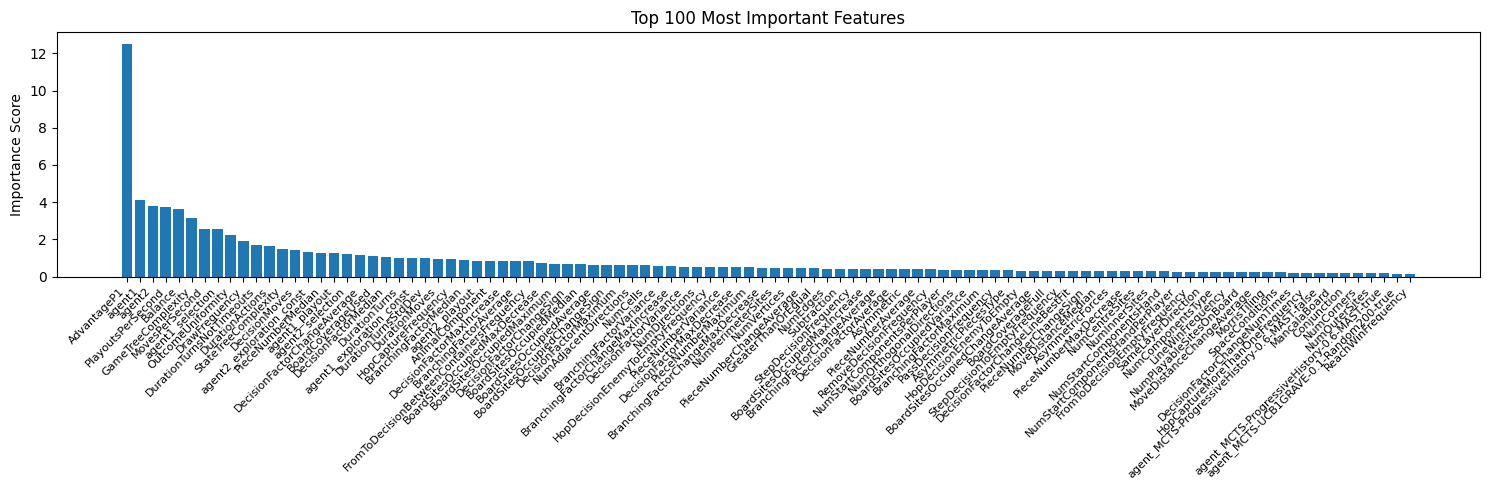

Fold 1 - RMSE: 0.4246804602332639
Fold 2


0:	learn: 0.6085854	test: 0.5696302	best: 0.5696302 (0)	total: 83.2ms	remaining: 4m 9s


50:	learn: 0.3884999	test: 0.4662421	best: 0.4662421 (50)	total: 4.72s	remaining: 4m 32s


100:	learn: 0.3506511	test: 0.4450167	best: 0.4450167 (100)	total: 9.59s	remaining: 4m 35s


150:	learn: 0.3257716	test: 0.4347434	best: 0.4347434 (150)	total: 14.2s	remaining: 4m 28s


200:	learn: 0.3099727	test: 0.4300893	best: 0.4300893 (200)	total: 19s	remaining: 4m 24s


250:	learn: 0.2990183	test: 0.4272178	best: 0.4272178 (250)	total: 23.8s	remaining: 4m 20s


300:	learn: 0.2890881	test: 0.4248653	best: 0.4248653 (300)	total: 28.5s	remaining: 4m 15s


350:	learn: 0.2814371	test: 0.4231904	best: 0.4231904 (350)	total: 33.4s	remaining: 4m 12s


400:	learn: 0.2744250	test: 0.4214455	best: 0.4214406 (399)	total: 38.2s	remaining: 4m 7s


450:	learn: 0.2678080	test: 0.4203564	best: 0.4203446 (448)	total: 43s	remaining: 4m 2s


500:	learn: 0.2624041	test: 0.4192228	best: 0.4192221 (497)	total: 47.8s	remaining: 3m 58s


550:	learn: 0.2572535	test: 0.4185920	best: 0.4185830 (549)	total: 52.6s	remaining: 3m 53s


600:	learn: 0.2530295	test: 0.4180839	best: 0.4180839 (600)	total: 57.4s	remaining: 3m 49s


650:	learn: 0.2486472	test: 0.4174982	best: 0.4174813 (649)	total: 1m 2s	remaining: 3m 44s


700:	learn: 0.2447991	test: 0.4169652	best: 0.4169503 (698)	total: 1m 6s	remaining: 3m 39s


750:	learn: 0.2410922	test: 0.4163414	best: 0.4163414 (750)	total: 1m 11s	remaining: 3m 35s


800:	learn: 0.2376784	test: 0.4159641	best: 0.4159412 (799)	total: 1m 16s	remaining: 3m 30s


850:	learn: 0.2342377	test: 0.4156509	best: 0.4156287 (846)	total: 1m 21s	remaining: 3m 25s


900:	learn: 0.2314590	test: 0.4154891	best: 0.4154891 (900)	total: 1m 26s	remaining: 3m 20s


950:	learn: 0.2285506	test: 0.4150888	best: 0.4150888 (950)	total: 1m 31s	remaining: 3m 16s


1000:	learn: 0.2260385	test: 0.4151503	best: 0.4150808 (959)	total: 1m 35s	remaining: 3m 11s


1050:	learn: 0.2235179	test: 0.4149055	best: 0.4149052 (1049)	total: 1m 40s	remaining: 3m 6s


1100:	learn: 0.2212184	test: 0.4147313	best: 0.4147313 (1100)	total: 1m 45s	remaining: 3m 1s


1150:	learn: 0.2189559	test: 0.4147250	best: 0.4147075 (1148)	total: 1m 50s	remaining: 2m 57s


1200:	learn: 0.2168215	test: 0.4144955	best: 0.4144955 (1200)	total: 1m 54s	remaining: 2m 52s


1250:	learn: 0.2147564	test: 0.4143561	best: 0.4143027 (1242)	total: 1m 59s	remaining: 2m 47s


1300:	learn: 0.2126910	test: 0.4143481	best: 0.4142895 (1285)	total: 2m 4s	remaining: 2m 42s


1350:	learn: 0.2107761	test: 0.4142199	best: 0.4141959 (1344)	total: 2m 9s	remaining: 2m 38s


1400:	learn: 0.2089198	test: 0.4141087	best: 0.4140957 (1386)	total: 2m 14s	remaining: 2m 33s


1450:	learn: 0.2070564	test: 0.4140346	best: 0.4140270 (1438)	total: 2m 19s	remaining: 2m 28s


1500:	learn: 0.2051679	test: 0.4139091	best: 0.4138974 (1484)	total: 2m 23s	remaining: 2m 23s


1550:	learn: 0.2033470	test: 0.4138270	best: 0.4138085 (1540)	total: 2m 28s	remaining: 2m 18s


1600:	learn: 0.2017431	test: 0.4137557	best: 0.4137417 (1596)	total: 2m 33s	remaining: 2m 13s


1650:	learn: 0.2001154	test: 0.4137066	best: 0.4136952 (1646)	total: 2m 38s	remaining: 2m 9s


1700:	learn: 0.1985493	test: 0.4135488	best: 0.4135488 (1700)	total: 2m 42s	remaining: 2m 4s


1750:	learn: 0.1968840	test: 0.4136126	best: 0.4135441 (1702)	total: 2m 47s	remaining: 1m 59s


1800:	learn: 0.1954451	test: 0.4135704	best: 0.4135271 (1787)	total: 2m 52s	remaining: 1m 54s


1850:	learn: 0.1939755	test: 0.4135825	best: 0.4135271 (1787)	total: 2m 57s	remaining: 1m 50s


1900:	learn: 0.1924118	test: 0.4135241	best: 0.4135241 (1900)	total: 3m 2s	remaining: 1m 45s


1950:	learn: 0.1909441	test: 0.4135004	best: 0.4134825 (1936)	total: 3m 7s	remaining: 1m 40s


2000:	learn: 0.1894928	test: 0.4134594	best: 0.4134594 (2000)	total: 3m 11s	remaining: 1m 35s


2050:	learn: 0.1879841	test: 0.4134861	best: 0.4133926 (2027)	total: 3m 16s	remaining: 1m 30s


2100:	learn: 0.1864663	test: 0.4134199	best: 0.4133926 (2027)	total: 3m 21s	remaining: 1m 26s


2150:	learn: 0.1851275	test: 0.4134620	best: 0.4133926 (2027)	total: 3m 26s	remaining: 1m 21s


2200:	learn: 0.1837557	test: 0.4134907	best: 0.4133926 (2027)	total: 3m 30s	remaining: 1m 16s


2250:	learn: 0.1823757	test: 0.4134067	best: 0.4133926 (2027)	total: 3m 35s	remaining: 1m 11s


2300:	learn: 0.1810949	test: 0.4134029	best: 0.4133807 (2254)	total: 3m 40s	remaining: 1m 7s


2350:	learn: 0.1798421	test: 0.4133518	best: 0.4133382 (2325)	total: 3m 45s	remaining: 1m 2s


2400:	learn: 0.1786369	test: 0.4133251	best: 0.4133149 (2374)	total: 3m 50s	remaining: 57.5s


2450:	learn: 0.1774776	test: 0.4132589	best: 0.4132589 (2450)	total: 3m 55s	remaining: 52.7s


2500:	learn: 0.1762561	test: 0.4132507	best: 0.4132436 (2453)	total: 3m 59s	remaining: 47.9s


2550:	learn: 0.1750741	test: 0.4133058	best: 0.4132436 (2453)	total: 4m 4s	remaining: 43.1s


2600:	learn: 0.1739303	test: 0.4132876	best: 0.4132436 (2453)	total: 4m 9s	remaining: 38.3s


2650:	learn: 0.1728601	test: 0.4132210	best: 0.4132183 (2644)	total: 4m 14s	remaining: 33.5s


2700:	learn: 0.1717007	test: 0.4132434	best: 0.4132162 (2655)	total: 4m 19s	remaining: 28.7s


2750:	learn: 0.1705424	test: 0.4132173	best: 0.4132009 (2722)	total: 4m 24s	remaining: 23.9s


2800:	learn: 0.1694037	test: 0.4131314	best: 0.4131314 (2800)	total: 4m 28s	remaining: 19.1s


2850:	learn: 0.1682028	test: 0.4131277	best: 0.4131141 (2821)	total: 4m 33s	remaining: 14.3s


2900:	learn: 0.1671096	test: 0.4131495	best: 0.4131141 (2821)	total: 4m 38s	remaining: 9.5s


2950:	learn: 0.1660894	test: 0.4130906	best: 0.4130906 (2950)	total: 4m 43s	remaining: 4.71s


2999:	learn: 0.1650083	test: 0.4131190	best: 0.4130901 (2952)	total: 4m 48s	remaining: 0us

bestTest = 0.4130900866
bestIteration = 2952

Shrink model to first 2953 iterations.


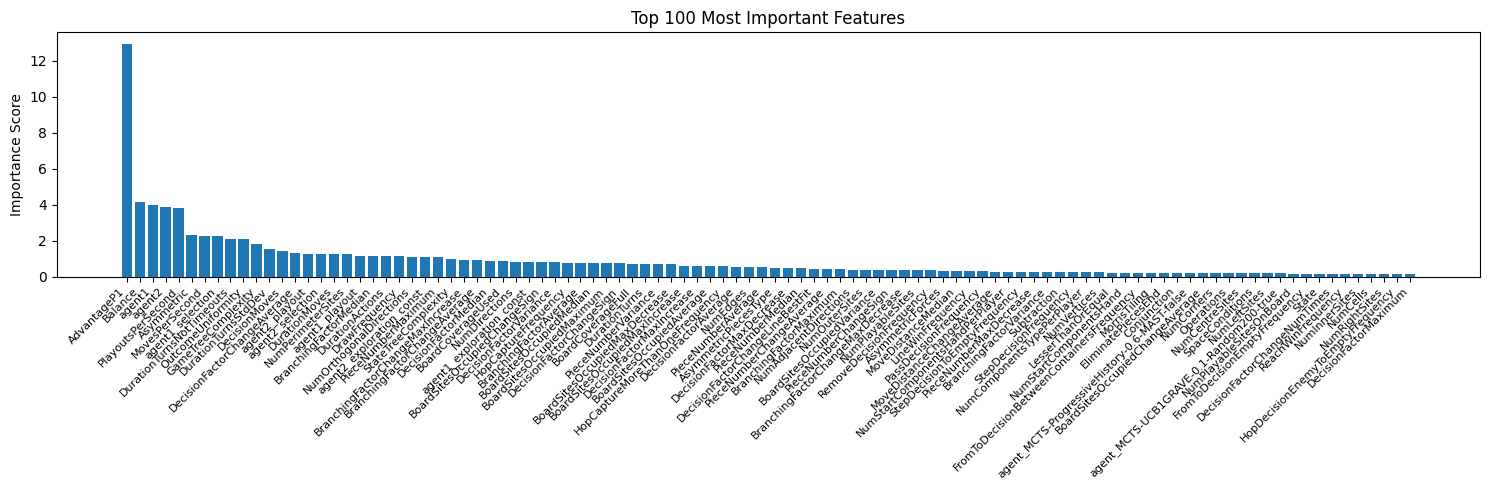

Fold 2 - RMSE: 0.41264448175686563
Fold 3


0:	learn: 0.6105690	test: 0.5726891	best: 0.5726891 (0)	total: 84.5ms	remaining: 4m 13s


50:	learn: 0.3864272	test: 0.4591655	best: 0.4591655 (50)	total: 4.5s	remaining: 4m 20s


100:	learn: 0.3448744	test: 0.4405925	best: 0.4405925 (100)	total: 9.19s	remaining: 4m 23s


150:	learn: 0.3243283	test: 0.4335691	best: 0.4335691 (150)	total: 13.8s	remaining: 4m 20s


200:	learn: 0.3096072	test: 0.4293753	best: 0.4293753 (200)	total: 18.4s	remaining: 4m 16s


250:	learn: 0.2984817	test: 0.4270253	best: 0.4269730 (249)	total: 23.1s	remaining: 4m 13s


300:	learn: 0.2896834	test: 0.4251131	best: 0.4251131 (300)	total: 27.8s	remaining: 4m 9s


350:	learn: 0.2816600	test: 0.4235365	best: 0.4235365 (350)	total: 32.5s	remaining: 4m 5s


400:	learn: 0.2745487	test: 0.4220930	best: 0.4220930 (400)	total: 37.2s	remaining: 4m


450:	learn: 0.2678375	test: 0.4210822	best: 0.4210822 (450)	total: 41.8s	remaining: 3m 56s


500:	learn: 0.2619210	test: 0.4201006	best: 0.4200877 (496)	total: 46.4s	remaining: 3m 51s


550:	learn: 0.2566928	test: 0.4195200	best: 0.4195200 (550)	total: 51.1s	remaining: 3m 47s


600:	learn: 0.2520585	test: 0.4190467	best: 0.4190301 (598)	total: 55.8s	remaining: 3m 42s


650:	learn: 0.2479565	test: 0.4185484	best: 0.4185484 (650)	total: 1m	remaining: 3m 38s


700:	learn: 0.2438300	test: 0.4183176	best: 0.4183149 (691)	total: 1m 5s	remaining: 3m 34s


750:	learn: 0.2402600	test: 0.4179149	best: 0.4179149 (750)	total: 1m 9s	remaining: 3m 29s


800:	learn: 0.2367567	test: 0.4175887	best: 0.4175797 (799)	total: 1m 14s	remaining: 3m 25s


850:	learn: 0.2333140	test: 0.4171881	best: 0.4171881 (850)	total: 1m 19s	remaining: 3m 20s


900:	learn: 0.2302761	test: 0.4170145	best: 0.4169595 (877)	total: 1m 24s	remaining: 3m 15s


950:	learn: 0.2274013	test: 0.4168700	best: 0.4168700 (950)	total: 1m 28s	remaining: 3m 11s


1000:	learn: 0.2245862	test: 0.4165806	best: 0.4165806 (1000)	total: 1m 33s	remaining: 3m 6s


1050:	learn: 0.2220000	test: 0.4165034	best: 0.4164737 (1033)	total: 1m 38s	remaining: 3m 1s


1100:	learn: 0.2194774	test: 0.4164920	best: 0.4164717 (1088)	total: 1m 42s	remaining: 2m 57s


1150:	learn: 0.2170706	test: 0.4160914	best: 0.4160890 (1149)	total: 1m 47s	remaining: 2m 52s


1200:	learn: 0.2148582	test: 0.4159840	best: 0.4159730 (1189)	total: 1m 52s	remaining: 2m 48s


1250:	learn: 0.2127508	test: 0.4159406	best: 0.4159228 (1235)	total: 1m 56s	remaining: 2m 43s


1300:	learn: 0.2106589	test: 0.4159071	best: 0.4158403 (1286)	total: 2m 1s	remaining: 2m 38s


1350:	learn: 0.2085879	test: 0.4158055	best: 0.4157693 (1344)	total: 2m 6s	remaining: 2m 34s


1400:	learn: 0.2066295	test: 0.4156401	best: 0.4156189 (1398)	total: 2m 11s	remaining: 2m 29s


1450:	learn: 0.2048646	test: 0.4153359	best: 0.4153280 (1441)	total: 2m 15s	remaining: 2m 25s


1500:	learn: 0.2030609	test: 0.4152917	best: 0.4152775 (1478)	total: 2m 20s	remaining: 2m 20s


1550:	learn: 0.2014026	test: 0.4151982	best: 0.4151905 (1549)	total: 2m 25s	remaining: 2m 15s


1600:	learn: 0.1996252	test: 0.4152021	best: 0.4151669 (1585)	total: 2m 30s	remaining: 2m 11s


1650:	learn: 0.1980075	test: 0.4150338	best: 0.4150284 (1647)	total: 2m 34s	remaining: 2m 6s


1700:	learn: 0.1964111	test: 0.4149424	best: 0.4149136 (1686)	total: 2m 39s	remaining: 2m 1s


1750:	learn: 0.1946465	test: 0.4150426	best: 0.4149136 (1686)	total: 2m 44s	remaining: 1m 57s


1800:	learn: 0.1929916	test: 0.4149229	best: 0.4149131 (1788)	total: 2m 49s	remaining: 1m 52s


1850:	learn: 0.1914595	test: 0.4148924	best: 0.4148625 (1823)	total: 2m 53s	remaining: 1m 47s


1900:	learn: 0.1900529	test: 0.4148236	best: 0.4148188 (1893)	total: 2m 58s	remaining: 1m 43s


1950:	learn: 0.1885192	test: 0.4147334	best: 0.4147332 (1949)	total: 3m 3s	remaining: 1m 38s


2000:	learn: 0.1870398	test: 0.4146219	best: 0.4146135 (1997)	total: 3m 7s	remaining: 1m 33s


2050:	learn: 0.1855851	test: 0.4146522	best: 0.4146135 (1997)	total: 3m 12s	remaining: 1m 29s


2100:	learn: 0.1842574	test: 0.4146576	best: 0.4146135 (1997)	total: 3m 17s	remaining: 1m 24s


2150:	learn: 0.1827900	test: 0.4146382	best: 0.4146135 (1997)	total: 3m 22s	remaining: 1m 19s


2200:	learn: 0.1813393	test: 0.4145139	best: 0.4145122 (2199)	total: 3m 26s	remaining: 1m 15s


2250:	learn: 0.1800801	test: 0.4144607	best: 0.4144524 (2248)	total: 3m 31s	remaining: 1m 10s


2300:	learn: 0.1787524	test: 0.4144582	best: 0.4144524 (2248)	total: 3m 36s	remaining: 1m 5s


2350:	learn: 0.1774825	test: 0.4143669	best: 0.4143355 (2310)	total: 3m 41s	remaining: 1m 1s


2400:	learn: 0.1761998	test: 0.4143329	best: 0.4143329 (2400)	total: 3m 45s	remaining: 56.3s


2450:	learn: 0.1749882	test: 0.4142345	best: 0.4142345 (2449)	total: 3m 50s	remaining: 51.6s


2500:	learn: 0.1736754	test: 0.4141844	best: 0.4141816 (2474)	total: 3m 55s	remaining: 47s


2550:	learn: 0.1723991	test: 0.4142358	best: 0.4141674 (2510)	total: 4m	remaining: 42.3s


2600:	learn: 0.1713566	test: 0.4142865	best: 0.4141674 (2510)	total: 4m 4s	remaining: 37.6s


2650:	learn: 0.1702098	test: 0.4143118	best: 0.4141674 (2510)	total: 4m 9s	remaining: 32.9s


2700:	learn: 0.1690539	test: 0.4142342	best: 0.4141674 (2510)	total: 4m 14s	remaining: 28.2s


2750:	learn: 0.1678555	test: 0.4142263	best: 0.4141674 (2510)	total: 4m 19s	remaining: 23.5s


2800:	learn: 0.1666329	test: 0.4142433	best: 0.4141674 (2510)	total: 4m 24s	remaining: 18.8s


2850:	learn: 0.1654894	test: 0.4142548	best: 0.4141674 (2510)	total: 4m 28s	remaining: 14s


2900:	learn: 0.1644609	test: 0.4142151	best: 0.4141674 (2510)	total: 4m 33s	remaining: 9.33s


2950:	learn: 0.1633524	test: 0.4142551	best: 0.4141674 (2510)	total: 4m 38s	remaining: 4.62s


2999:	learn: 0.1624030	test: 0.4142727	best: 0.4141674 (2510)	total: 4m 42s	remaining: 0us

bestTest = 0.4141674347
bestIteration = 2510

Shrink model to first 2511 iterations.


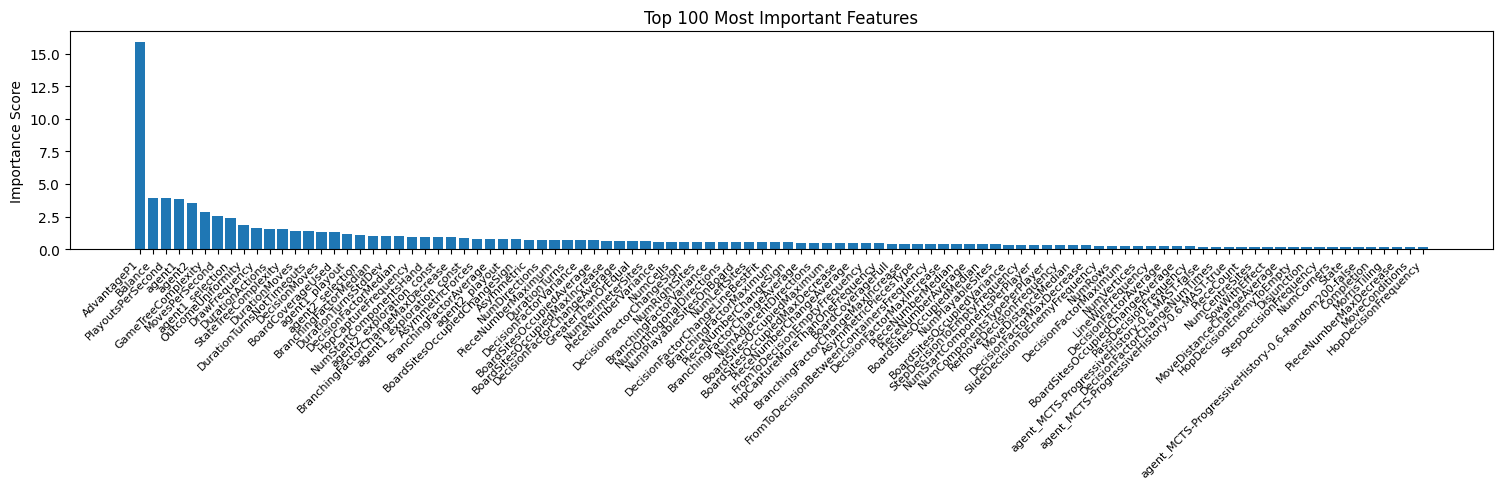

Fold 3 - RMSE: 0.4135221212677242
Fold 4


0:	learn: 0.6099538	test: 0.5668602	best: 0.5668602 (0)	total: 87.1ms	remaining: 4m 21s


50:	learn: 0.3871464	test: 0.4582378	best: 0.4582378 (50)	total: 4.62s	remaining: 4m 27s


100:	learn: 0.3469470	test: 0.4438015	best: 0.4438015 (100)	total: 9.35s	remaining: 4m 28s


150:	learn: 0.3238221	test: 0.4365039	best: 0.4365039 (150)	total: 14.1s	remaining: 4m 25s


200:	learn: 0.3084654	test: 0.4314314	best: 0.4314314 (200)	total: 18.8s	remaining: 4m 21s


250:	learn: 0.2968423	test: 0.4284364	best: 0.4284364 (250)	total: 23.5s	remaining: 4m 17s


300:	learn: 0.2875596	test: 0.4267532	best: 0.4267532 (300)	total: 28.3s	remaining: 4m 13s


350:	learn: 0.2787158	test: 0.4247217	best: 0.4247201 (349)	total: 33s	remaining: 4m 9s


400:	learn: 0.2718511	test: 0.4234945	best: 0.4234633 (399)	total: 37.8s	remaining: 4m 4s


450:	learn: 0.2659651	test: 0.4229818	best: 0.4228278 (440)	total: 42.5s	remaining: 4m


500:	learn: 0.2601865	test: 0.4220660	best: 0.4220660 (500)	total: 47.3s	remaining: 3m 55s


550:	learn: 0.2555046	test: 0.4215290	best: 0.4215253 (548)	total: 52.1s	remaining: 3m 51s


600:	learn: 0.2510707	test: 0.4207830	best: 0.4207830 (600)	total: 56.9s	remaining: 3m 47s


650:	learn: 0.2469166	test: 0.4201913	best: 0.4201913 (650)	total: 1m 1s	remaining: 3m 42s


700:	learn: 0.2435321	test: 0.4196505	best: 0.4196421 (697)	total: 1m 6s	remaining: 3m 38s


750:	learn: 0.2396213	test: 0.4192952	best: 0.4192612 (743)	total: 1m 11s	remaining: 3m 33s


800:	learn: 0.2364420	test: 0.4188164	best: 0.4188164 (800)	total: 1m 15s	remaining: 3m 28s


850:	learn: 0.2335800	test: 0.4184143	best: 0.4183959 (847)	total: 1m 20s	remaining: 3m 23s


900:	learn: 0.2307009	test: 0.4180437	best: 0.4180437 (900)	total: 1m 25s	remaining: 3m 18s


950:	learn: 0.2279199	test: 0.4176723	best: 0.4176634 (945)	total: 1m 30s	remaining: 3m 14s


1000:	learn: 0.2252556	test: 0.4174140	best: 0.4174140 (1000)	total: 1m 34s	remaining: 3m 9s


1050:	learn: 0.2227517	test: 0.4172295	best: 0.4172240 (1048)	total: 1m 39s	remaining: 3m 4s


1100:	learn: 0.2203824	test: 0.4170976	best: 0.4170976 (1100)	total: 1m 44s	remaining: 3m


1150:	learn: 0.2184261	test: 0.4170066	best: 0.4169994 (1148)	total: 1m 49s	remaining: 2m 55s


1200:	learn: 0.2163313	test: 0.4170346	best: 0.4169994 (1148)	total: 1m 54s	remaining: 2m 50s


1250:	learn: 0.2140241	test: 0.4169386	best: 0.4169209 (1231)	total: 1m 58s	remaining: 2m 46s


1300:	learn: 0.2121135	test: 0.4168047	best: 0.4167839 (1294)	total: 2m 3s	remaining: 2m 41s


1350:	learn: 0.2101612	test: 0.4167963	best: 0.4167721 (1324)	total: 2m 8s	remaining: 2m 36s


1400:	learn: 0.2082366	test: 0.4166877	best: 0.4166766 (1397)	total: 2m 13s	remaining: 2m 31s


1450:	learn: 0.2064102	test: 0.4166272	best: 0.4166272 (1450)	total: 2m 17s	remaining: 2m 27s


1500:	learn: 0.2045869	test: 0.4165326	best: 0.4165065 (1491)	total: 2m 22s	remaining: 2m 22s


1550:	learn: 0.2027499	test: 0.4164993	best: 0.4164993 (1550)	total: 2m 27s	remaining: 2m 17s


1600:	learn: 0.2009580	test: 0.4164942	best: 0.4164696 (1586)	total: 2m 31s	remaining: 2m 12s


1650:	learn: 0.1993484	test: 0.4164596	best: 0.4164575 (1649)	total: 2m 36s	remaining: 2m 8s


1700:	learn: 0.1976941	test: 0.4164712	best: 0.4164309 (1673)	total: 2m 41s	remaining: 2m 3s


1750:	learn: 0.1960407	test: 0.4165254	best: 0.4164309 (1673)	total: 2m 46s	remaining: 1m 58s


1800:	learn: 0.1946192	test: 0.4165091	best: 0.4164309 (1673)	total: 2m 51s	remaining: 1m 53s


1850:	learn: 0.1930031	test: 0.4164796	best: 0.4164309 (1673)	total: 2m 55s	remaining: 1m 49s


1900:	learn: 0.1913933	test: 0.4163926	best: 0.4163919 (1899)	total: 3m	remaining: 1m 44s


1950:	learn: 0.1898821	test: 0.4163062	best: 0.4162862 (1948)	total: 3m 5s	remaining: 1m 39s


2000:	learn: 0.1883352	test: 0.4163257	best: 0.4162650 (1971)	total: 3m 9s	remaining: 1m 34s


2050:	learn: 0.1868474	test: 0.4163274	best: 0.4162650 (1971)	total: 3m 14s	remaining: 1m 30s


2100:	learn: 0.1853922	test: 0.4162914	best: 0.4162650 (1971)	total: 3m 19s	remaining: 1m 25s


2150:	learn: 0.1840334	test: 0.4162581	best: 0.4162231 (2128)	total: 3m 24s	remaining: 1m 20s


2200:	learn: 0.1825847	test: 0.4161923	best: 0.4161923 (2200)	total: 3m 29s	remaining: 1m 15s


2250:	learn: 0.1812548	test: 0.4162500	best: 0.4161630 (2216)	total: 3m 33s	remaining: 1m 11s


2300:	learn: 0.1799725	test: 0.4162279	best: 0.4161630 (2216)	total: 3m 38s	remaining: 1m 6s


2350:	learn: 0.1786919	test: 0.4161874	best: 0.4161630 (2216)	total: 3m 43s	remaining: 1m 1s


2400:	learn: 0.1774284	test: 0.4161584	best: 0.4161230 (2398)	total: 3m 48s	remaining: 56.9s


2450:	learn: 0.1761073	test: 0.4162009	best: 0.4161230 (2398)	total: 3m 52s	remaining: 52.2s


2500:	learn: 0.1749147	test: 0.4161834	best: 0.4161230 (2398)	total: 3m 57s	remaining: 47.4s


2550:	learn: 0.1736932	test: 0.4161479	best: 0.4161230 (2398)	total: 4m 2s	remaining: 42.7s


2600:	learn: 0.1725610	test: 0.4161260	best: 0.4161230 (2398)	total: 4m 7s	remaining: 37.9s


2650:	learn: 0.1713683	test: 0.4161471	best: 0.4161230 (2398)	total: 4m 11s	remaining: 33.2s


2700:	learn: 0.1701982	test: 0.4161963	best: 0.4161230 (2398)	total: 4m 16s	remaining: 28.4s


2750:	learn: 0.1691574	test: 0.4161587	best: 0.4161230 (2398)	total: 4m 21s	remaining: 23.7s


2800:	learn: 0.1680844	test: 0.4162132	best: 0.4161230 (2398)	total: 4m 26s	remaining: 18.9s


2850:	learn: 0.1670255	test: 0.4162219	best: 0.4161230 (2398)	total: 4m 31s	remaining: 14.2s


2900:	learn: 0.1659682	test: 0.4162654	best: 0.4161230 (2398)	total: 4m 35s	remaining: 9.41s


2950:	learn: 0.1648812	test: 0.4162741	best: 0.4161230 (2398)	total: 4m 40s	remaining: 4.66s


2999:	learn: 0.1638574	test: 0.4162020	best: 0.4161230 (2398)	total: 4m 45s	remaining: 0us

bestTest = 0.4161230242
bestIteration = 2398

Shrink model to first 2399 iterations.


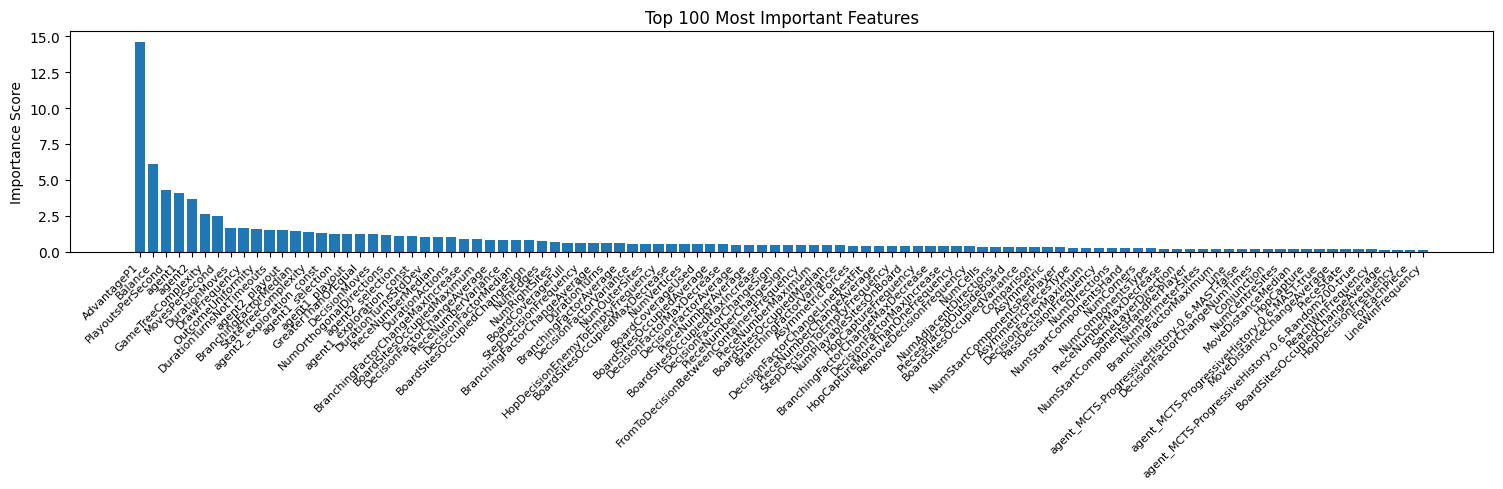

Fold 4 - RMSE: 0.41539716432295015
Fold 5


0:	learn: 0.6048545	test: 0.5771478	best: 0.5771478 (0)	total: 75.8ms	remaining: 3m 47s


50:	learn: 0.3872350	test: 0.4764526	best: 0.4764526 (50)	total: 4.58s	remaining: 4m 24s


100:	learn: 0.3477255	test: 0.4556969	best: 0.4556969 (100)	total: 9.39s	remaining: 4m 29s


150:	learn: 0.3246666	test: 0.4461894	best: 0.4461894 (150)	total: 14.2s	remaining: 4m 27s


200:	learn: 0.3097235	test: 0.4416946	best: 0.4416946 (200)	total: 19s	remaining: 4m 24s


250:	learn: 0.2977096	test: 0.4386568	best: 0.4386545 (249)	total: 23.9s	remaining: 4m 21s


300:	learn: 0.2879856	test: 0.4366311	best: 0.4366311 (300)	total: 28.7s	remaining: 4m 17s


350:	learn: 0.2801992	test: 0.4348180	best: 0.4348180 (350)	total: 33.5s	remaining: 4m 12s


400:	learn: 0.2731770	test: 0.4331832	best: 0.4331832 (400)	total: 38.3s	remaining: 4m 8s


450:	learn: 0.2670917	test: 0.4321907	best: 0.4321907 (450)	total: 43.2s	remaining: 4m 4s


500:	learn: 0.2612971	test: 0.4314584	best: 0.4314463 (490)	total: 48.1s	remaining: 4m


550:	learn: 0.2564555	test: 0.4305286	best: 0.4305176 (546)	total: 53s	remaining: 3m 55s


600:	learn: 0.2515069	test: 0.4297439	best: 0.4297439 (600)	total: 57.9s	remaining: 3m 50s


650:	learn: 0.2472752	test: 0.4293030	best: 0.4292560 (649)	total: 1m 2s	remaining: 3m 46s


700:	learn: 0.2434008	test: 0.4290217	best: 0.4290156 (698)	total: 1m 7s	remaining: 3m 41s


750:	learn: 0.2397883	test: 0.4289610	best: 0.4288506 (731)	total: 1m 12s	remaining: 3m 36s


800:	learn: 0.2361455	test: 0.4286431	best: 0.4286387 (799)	total: 1m 17s	remaining: 3m 32s


850:	learn: 0.2328924	test: 0.4285703	best: 0.4285703 (850)	total: 1m 22s	remaining: 3m 27s


900:	learn: 0.2300763	test: 0.4283961	best: 0.4283961 (900)	total: 1m 26s	remaining: 3m 22s


950:	learn: 0.2272203	test: 0.4280500	best: 0.4279940 (943)	total: 1m 31s	remaining: 3m 17s


1000:	learn: 0.2245541	test: 0.4278035	best: 0.4278035 (1000)	total: 1m 36s	remaining: 3m 13s


1050:	learn: 0.2221579	test: 0.4276174	best: 0.4276174 (1050)	total: 1m 41s	remaining: 3m 8s


1100:	learn: 0.2199856	test: 0.4273791	best: 0.4273791 (1100)	total: 1m 46s	remaining: 3m 3s


1150:	learn: 0.2176480	test: 0.4271641	best: 0.4271413 (1147)	total: 1m 51s	remaining: 2m 58s


1200:	learn: 0.2155768	test: 0.4271099	best: 0.4271071 (1157)	total: 1m 56s	remaining: 2m 54s


1250:	learn: 0.2135181	test: 0.4269613	best: 0.4269294 (1241)	total: 2m 1s	remaining: 2m 49s


1300:	learn: 0.2115415	test: 0.4268492	best: 0.4267881 (1282)	total: 2m 6s	remaining: 2m 44s


1350:	learn: 0.2094887	test: 0.4269352	best: 0.4267881 (1282)	total: 2m 10s	remaining: 2m 39s


1400:	learn: 0.2076269	test: 0.4268460	best: 0.4267881 (1282)	total: 2m 15s	remaining: 2m 34s


1450:	learn: 0.2057978	test: 0.4268288	best: 0.4267881 (1282)	total: 2m 20s	remaining: 2m 30s


1500:	learn: 0.2041048	test: 0.4268132	best: 0.4267877 (1458)	total: 2m 25s	remaining: 2m 25s


1550:	learn: 0.2024403	test: 0.4268050	best: 0.4267578 (1529)	total: 2m 30s	remaining: 2m 20s


1600:	learn: 0.2008471	test: 0.4266840	best: 0.4266840 (1600)	total: 2m 35s	remaining: 2m 15s


1650:	learn: 0.1991687	test: 0.4266889	best: 0.4266753 (1617)	total: 2m 40s	remaining: 2m 11s


1700:	learn: 0.1975110	test: 0.4266833	best: 0.4266631 (1657)	total: 2m 45s	remaining: 2m 6s


1750:	learn: 0.1960545	test: 0.4266573	best: 0.4266228 (1726)	total: 2m 50s	remaining: 2m 1s


1800:	learn: 0.1945775	test: 0.4265981	best: 0.4265981 (1800)	total: 2m 55s	remaining: 1m 56s


1850:	learn: 0.1929952	test: 0.4265895	best: 0.4265668 (1807)	total: 2m 59s	remaining: 1m 51s


1900:	learn: 0.1914838	test: 0.4265447	best: 0.4265270 (1878)	total: 3m 4s	remaining: 1m 46s


1950:	learn: 0.1900126	test: 0.4264572	best: 0.4264360 (1944)	total: 3m 9s	remaining: 1m 42s


2000:	learn: 0.1885017	test: 0.4263829	best: 0.4263616 (1994)	total: 3m 14s	remaining: 1m 37s


2050:	learn: 0.1870728	test: 0.4263612	best: 0.4263428 (2045)	total: 3m 19s	remaining: 1m 32s


2100:	learn: 0.1857030	test: 0.4264033	best: 0.4263428 (2045)	total: 3m 24s	remaining: 1m 27s


2150:	learn: 0.1843537	test: 0.4264594	best: 0.4263428 (2045)	total: 3m 29s	remaining: 1m 22s


2200:	learn: 0.1830213	test: 0.4265413	best: 0.4263428 (2045)	total: 3m 34s	remaining: 1m 17s


2250:	learn: 0.1817844	test: 0.4265078	best: 0.4263428 (2045)	total: 3m 38s	remaining: 1m 12s


2300:	learn: 0.1804562	test: 0.4264843	best: 0.4263428 (2045)	total: 3m 43s	remaining: 1m 7s


2350:	learn: 0.1791919	test: 0.4264853	best: 0.4263428 (2045)	total: 3m 48s	remaining: 1m 3s


2400:	learn: 0.1779668	test: 0.4264851	best: 0.4263428 (2045)	total: 3m 53s	remaining: 58.3s


2450:	learn: 0.1767393	test: 0.4264668	best: 0.4263428 (2045)	total: 3m 58s	remaining: 53.4s


2500:	learn: 0.1753629	test: 0.4264443	best: 0.4263428 (2045)	total: 4m 3s	remaining: 48.6s


2550:	learn: 0.1742243	test: 0.4264862	best: 0.4263428 (2045)	total: 4m 8s	remaining: 43.7s


2600:	learn: 0.1730443	test: 0.4264955	best: 0.4263428 (2045)	total: 4m 13s	remaining: 38.8s


2650:	learn: 0.1718652	test: 0.4265001	best: 0.4263428 (2045)	total: 4m 18s	remaining: 34s


2700:	learn: 0.1707012	test: 0.4264580	best: 0.4263428 (2045)	total: 4m 22s	remaining: 29.1s


2750:	learn: 0.1695856	test: 0.4264011	best: 0.4263428 (2045)	total: 4m 27s	remaining: 24.2s


2800:	learn: 0.1684165	test: 0.4264426	best: 0.4263428 (2045)	total: 4m 32s	remaining: 19.4s


2850:	learn: 0.1673667	test: 0.4264211	best: 0.4263428 (2045)	total: 4m 37s	remaining: 14.5s


2900:	learn: 0.1663464	test: 0.4263480	best: 0.4263418 (2897)	total: 4m 42s	remaining: 9.64s


2950:	learn: 0.1652791	test: 0.4263558	best: 0.4263278 (2910)	total: 4m 47s	remaining: 4.77s


2999:	learn: 0.1642664	test: 0.4263613	best: 0.4263278 (2910)	total: 4m 52s	remaining: 0us

bestTest = 0.4263278159
bestIteration = 2910

Shrink model to first 2911 iterations.


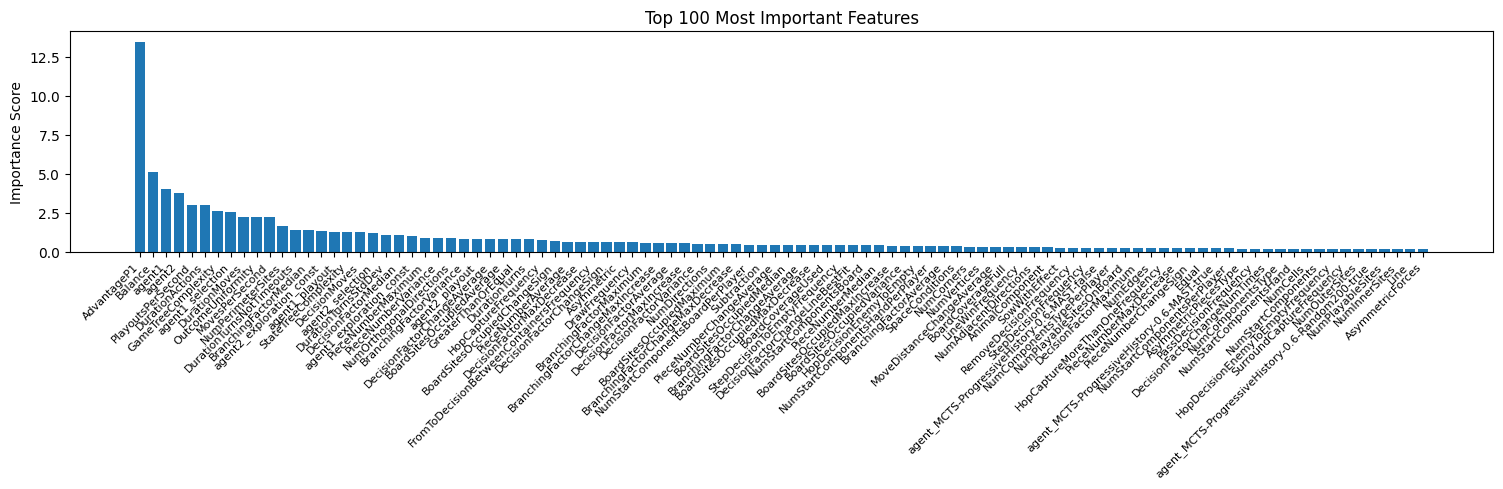

Fold 5 - RMSE: 0.4257208759144545
List of oof scores: [0.4246804602332639, 0.41264448175686563, 0.4135221212677242, 0.41539716432295015, 0.4257208759144545]
Average oof score: 0.41839302069905165


In [13]:
# call the function
trained_models3, oof3, oof_scores3, importance_df3 = train_models(
    df_train, 
    numerical_cols, 
    categorical_cols, 
    text_cols=text_cols,
    split_list=split3,
)
# save oof predictions
oof3.to_parquet(path_results / f'oof_catboost_{fs_type}_cv3.parquet', index=False)

In [14]:
# Print summary of OOF scores for each CV fold
print("CV1 OOF Scores:")
for score in oof_scores1:
    print(f"Score: {score:.4f}")
print(f"Average CV1 Score: {sum(oof_scores1)/len(oof_scores1):.4f}")
    
print("\nCV2 OOF Scores:")  
for score in oof_scores2:
    print(f"Score: {score:.4f}")
print(f"Average CV2 Score: {sum(oof_scores2)/len(oof_scores2):.4f}")
    
print("\nCV3 OOF Scores:")
for score in oof_scores3:
    print(f"Score: {score:.4f}")
print(f"Average CV3 Score: {sum(oof_scores3)/len(oof_scores3):.4f}")


CV1 OOF Scores:
Score: 0.4214
Score: 0.4412
Score: 0.4330
Score: 0.4374
Score: 0.4013
Average CV1 Score: 0.4269

CV2 OOF Scores:
Score: 0.4080
Score: 0.3945
Score: 0.4245
Score: 0.4391
Score: 0.4326
Average CV2 Score: 0.4197

CV3 OOF Scores:
Score: 0.4247
Score: 0.4126
Score: 0.4135
Score: 0.4154
Score: 0.4257
Average CV3 Score: 0.4184


In [15]:
trained_models = [*trained_models1, *trained_models2, *trained_models3]
# trained_models = trained_models1

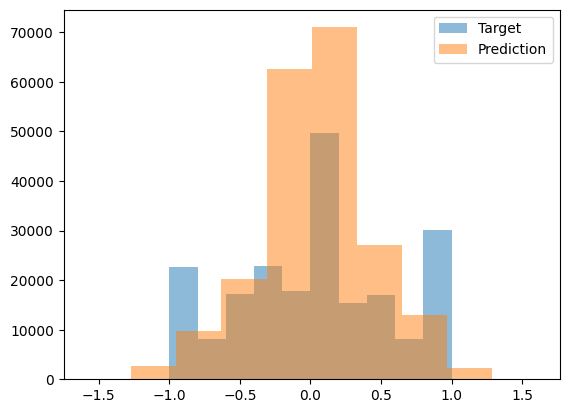

In [16]:
plt.hist(oof1['utility_agent1_true'], alpha=0.5, label='Target')
plt.hist(oof1['utility_agent1_pred'], alpha=0.5, label='Prediction')
plt.legend()
plt.show()

***
### inference

In [17]:
import os
import polars as pl
sys.path.append("../data/raw/")
import kaggle_evaluation.mcts_inference_server

In [18]:
def predict(test: pl.DataFrame, sample_sub: pl.DataFrame):
    # Convert Polars DataFrame to Pandas DataFrame
    test_pd = test.to_pandas()
    
    # Process the test data
    test_processed = process_test_data(
        test_pd,
        numerical_cols,
        categorical_cols,
        encoder,
        scaler,
        include_position_features=True,
        include_text_features=True,
    )

    # Create CatBoost Pool for test data
    test_pool = cb.Pool(
        # data=test_processed[numerical_cols + categorical_cols + text_cols],
        data=test_processed[numerical_cols + categorical_cols],
        cat_features=categorical_cols,
        # text_features=text_cols,
    )

    # Average predictions from all models
    predictions = np.mean([
        model.predict(test_pool)
        for model in trained_models
    ], axis=0)
    predictions = np.clip(predictions, -1, 1)
        
    # Create the submission DataFrame
    submission = sample_sub.with_columns(pl.Series("utility_agent1", predictions))
    
    return submission

In [19]:
# sanity check
df_test = pl.read_csv('../data/raw/test.csv')
sample_sub = pl.read_csv('../data/raw/sample_submission.csv')
predict(df_test, sample_sub)

shape: (3, 2)
┌────────┬────────────────┐
│ Id     ┆ utility_agent1 │
│ ---    ┆ ---            │
│ i64    ┆ f64            │
╞════════╪════════════════╡
│ 233234 ┆ 0.127013       │
│ 233235 ┆ -0.15161       │
│ 233236 ┆ -0.044114      │
└────────┴────────────────┘

In [20]:
inference_server = kaggle_evaluation.mcts_inference_server.MCTSInferenceServer(predict)

if os.getenv('KAGGLE_IS_COMPETITION_RERUN'):
    inference_server.serve()
else:
    inference_server.run_local_gateway(
        (
            '../data/raw/test.csv',
            '../data/raw/sample_submission.csv'
        )
    )

In [21]:
# Save all artifacts needed for prediction
catboost_predict = {
    'models': trained_models,
    'numerical_cols': numerical_cols,
    'categorical_cols': categorical_cols,
    'text_cols': text_cols,
    'encoder': encoder, 
    'scaler': scaler
}
with open(f'./catboost_predict_{fs_type}.pkl', 'wb') as f:
    pickle.dump(catboost_predict, f)

***